# Data Analysis 3 - First Home Assignment
## Author: Márton Nagy

## Part 1: Modelling
### 1.1. - Data wrangling

In [1]:
# general packages
import pandas as pd
import numpy as np
import math
import ast
from datetime import datetime
from time import time
from pathlib import Path
import dill
import json

# plotting
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import patchworklib as pw
from IPython.display import display
from mizani.formatters import percent_format

# data analysis
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import shap

# other
import warnings
import zipfile
warnings.filterwarnings("ignore")

from utils.py_helper_functions import *

<Figure size 100x100 with 0 Axes>

My chosen AirBnB dataset is: Milan (2024Q2). I will check the validity of my models on data from Milan (2024Q3) and Florence (2024Q2).

First, I read the raw CSV files (as they have been downloaded from the InsideAirBnB website).

In [ ]:
# read raw data files locally
#data_dir = 'raw_data'
#milanQ2 = pd.read_csv(Path(data_dir, 'Milan2024Q2.csv'), index_col = 0)
#milanQ3 = pd.read_csv(Path(data_dir, 'Milan2024Q3.csv'), index_col = 0)
#florenceQ2 = pd.read_csv(Path(data_dir, 'Florence2024Q2.csv'), index_col = 0)

In [2]:
# read raw data files from GitHub
milanQ2 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Milan2024Q2.csv',
                      index_col = 0)
milanQ3 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Milan2024Q3.csv',
                      index_col = 0)
florenceQ2 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Florence2024Q2.csv',
                         index_col = 0)

Sometimes when I worked with InsideAirBnB data, I noticed that different cities or timeframes may have different variables available. This may pose a problem in the sense, that if I build a model on Milan Q2 using some variables that are not available in the 'live' data, than my models would be practically useless.

Note that in this case, this is actually not a problem - but better to be safe than sorry.

In [3]:
# keep only such columns that are present in all dataframes
# for these dataframes, this actually does not drop anything
# but this may not be the case for other data
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

As I figured that I cannot use the neighbourhood variables for my models (as they would be completely different for Florence), I instead will calculate the distance to the city center (using the haversine formula) and use this instead.

In [4]:
def distance_to_center(lat, lon, center_lat, center_lon):
    # radius of Earth in kilometers
    R = 6371.0
    
    # convert degrees to radians
    lat1, lon1 = math.radians(center_lat), math.radians(center_lon)
    lat2, lon2 = math.radians(lat), math.radians(lon)
    
    # differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # distance in kilometers
    distance = R * c
    
    return distance

During development, I first cleaned the MilanQ2 table step-by-step, making a concious decision at every step. However, as I also have to clean two other datasets the same way, I decided to wrap the whole cleaning process inside a function.

The key steps of the cleaning process were:

- type conversions (and possibly cleaning values for that from unnecessary characters);
- imputing missing values - for categorical columns, I did this by adding a new 'Missing' category; for numerical columns I usually imputed with the median value (except for host response rate and host acceptance rate, where I imputed with zeros);
- deciding on the measurement scale for certain quantitative variables (categorical or numerical);
- creating flags for missing values for variables where a substantial amount was missing;
- filtering to a sensible subset by property type, number of people accomodated and minimum nights, and also filtering out observations with no target variable;
- making some new variables (days since host, days since first review, distance to center;
- creating dummies from the amenities and the host verification types.
    

In [5]:
def clean_df(df, center_lat, center_lon):
    df = df.copy() #not inplace

    # number of days the host is registered (no missing)
    df['n_host_since'] = (pd.to_datetime(df['last_scraped'], format = '%Y-%m-%d') - pd.to_datetime(df['host_since'], format = '%Y-%m-%d')).dt.days

    # host location Italy or Other, NAs imputed with missing category
    df['f_host_location'] = df['host_location'].apply(
        lambda x: 'Italy' if isinstance(x, str) and 'italy' in x.lower() else ('Missing' if pd.isna(x) else 'Other')).astype('category')

    # simple categorical, added Missing category for NAs
    df['f_host_response_time'] = df['host_response_time'].fillna('Missing').astype('category')

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_response_rate'] = df.host_response_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_acceptance_rate'] = df.host_acceptance_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to binary, no missing
    df['d_host_is_superhost'] = df.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)

    # added dummies for every possible host verification type (only three in practice)
    df = df.join(df['host_verifications'].apply(ast.literal_eval).apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int).add_prefix('d_hostverif_'))

    # converted to binary, no missing
    df['d_host_has_profile_pic'] = df.host_has_profile_pic.apply(lambda x: 1 if x == 't' else 0)

    # converted to binary, no missing
    df['d_host_identity_verified'] = df.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)

    # I figured that I should not use neighbourhood data in my models, as in the case of Florence live data, I will have completely different values
    # So instead, I will use distance to center (calculated by me).
    #df['f_neighbourhood'] = df.neighbourhood_cleansed.astype('category')

    # Filtering to a sensible set of property types
    df = df.loc[lambda x: x['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])]

    # Setting values to categories, no missing
    df['f_property_type'] = df.property_type.astype('category')

    # Setting values to categories, no missing
    df['f_room_type'] = df.room_type.astype('category')

    # Not interested in extremely big listings, filtering to max. 8 guests
    df = df[df['accommodates'] <= 8]
    df['n_accomodates'] = df.accommodates

    # Creating bathroom categories (0, 1, 2 and 2+)
    df['f_bathrooms'] = df.bathrooms.fillna(1).apply(lambda x: '0' if x < 1 else ('1' if (x >= 1 and x < 2) else ('2' if (x >= 2 and x < 3) else '2+'))).astype('category')

    # Imputing the number of bedrooms with the median
    df['n_bedrooms'] = df.bedrooms.fillna(np.median(df['bedrooms'].dropna()))

    # Imputing the number of beds with the number of possible guests
    df['n_beds'] = df.beds.fillna(df['accommodates'])

    # Adding a dummy for all possible amenities (will remove many later)
    df = df.join(df['amenities'].apply(lambda x: pd.Series(1, index=[amen.replace(' ', '_').replace('-', '_').lower() for amen in ast.literal_eval(x)])).add_prefix('d_amenities_').fillna(0).astype(int))

    # Dropping observations where no price (target), converting it to float
    df = df[df['price'].notna()]
    df['eur_price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

    # Interested in AirBnBs for short-term tourism: minimum nights should not be more than a week
    df = df[df['minimum_nights'] <= 7]

    # Categorizing the number of reviews: 0, 1-10, 11-30, 30+
    fnor = pd.cut(df['number_of_reviews'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 1), (1, 11), (11, 31), (31, max(df.number_of_reviews)+1)], closed="left"),
       labels=['0', '1-10', '11-30', '30+'])
    fnor = fnor.rename_categories([0, 1, 2, 3])
    df['f_number_of_reviews'] = fnor

    # Calculating number of days since the first review
    df["n_days_since_first_rev"] = (
    df.last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        - df.first_review.fillna("1950-01-01").apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d")
        )).dt.days
    df["n_days_since_first_rev"] = np.where(df.first_review.isnull(), np.nan, df.n_days_since_first_rev)

    # adding prefix, will deal with missing later
    df['n_review_scores_rating'] = df.review_scores_rating

    # converting to binary, no missing
    df['d_instant_bookable'] = df.instant_bookable.apply(lambda x: 1 if x == 't' else 0)

    # Categorizing host listings count: 1, 2-10, 10+
    hlc = pd.cut(df['calculated_host_listings_count'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 2), (2, 11), (11, max(df.calculated_host_listings_count)+1)], closed="left"),
       labels=['1', '2-10', '10+'])
    hlc = hlc.rename_categories([0, 1, 2])
    df['f_host_listings_count'] = hlc

    # Adding prefix, will deal with missing later
    df['n_reviews_per_month'] = df.reviews_per_month

    # calculating distance to city center
    df['n_distance_to_center'] = df.apply(lambda row: distance_to_center(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)

    # filtering to columns with prefixes
    df = df.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^eur_.*",)

    # creating flags for variables that had many missing values, and imputing with median
    df = df.assign(
        flag_n_days_since_first_rev = np.multiply(df.n_days_since_first_rev.isna(), 1),
        n_days_since_first_rev = df.n_days_since_first_rev.fillna(np.median(df.n_days_since_first_rev.dropna())),
        flag_n_review_scores_rating = np.multiply(df.n_review_scores_rating.isna(), 1),
        n_review_scores_rating = df.n_review_scores_rating.fillna(
            np.median(df.n_review_scores_rating.dropna())
        ),
        flag_n_reviews_per_month = np.multiply(df.n_reviews_per_month.isna(), 1),
        n_reviews_per_month = df.n_reviews_per_month.fillna(
            np.median(df.n_reviews_per_month.dropna())
        )
    )

    return df

For calculating the distance to center, I manually looked up the city center coordinates for both cities.

In [6]:
milan_lat = 45.464664
milan_lon = 9.188540
florence_lat = 43.769562
florence_lon  = 11.255814

Applying the cleaning function to MilanQ2.

In [7]:
milanQ2 = clean_df(milanQ2, milan_lat, milan_lon)

As there were a couple thousand different amenities in the dataset, I decided to only keep those, that were present at at least a quarter of the observations.

In [8]:
# keep only such amenities in our source data that are present at at least 25% of the listings
milanQ2.drop([col for col in milanQ2.columns if ('d_amenities' in col and milanQ2[col].sum() < milanQ2.shape[0]*0.25)], inplace = True, axis = 1)

Note that I apply the cleaning function here (that is actually task 5 in the assignment description). The reason for this is that I only want to have such amenities in my training data that are also present in the 'live' data as well.

In [9]:
milanQ3 = clean_df(milanQ3, milan_lat, milan_lon)

In [10]:
florenceQ2 = clean_df(florenceQ2, florence_lat, florence_lon)

In [11]:
# filter out such host_verifs and amenities that are not present in all tables
# the other cols are common as we have created them
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

I also add squared and cubed polynomials to my datasets.

In [12]:
def add_poly_vars(df):
    df = df.copy()
    numeric_cols = [col for col in df if col[0:2] == 'n_']
    for c in numeric_cols:
        df[f'sq_{c}'] = np.power(df[c], 2)
        df[f'cu_{c}'] = np.power(df[c], 3)
    return df

In [13]:
milanQ2 = add_poly_vars(milanQ2)
milanQ3 = add_poly_vars(milanQ3)
florenceQ2 = add_poly_vars(florenceQ2)

All in all, I am left with 20,730 observations in my MilanQ2 dataset.

In [14]:
milanQ2[[col for col in milanQ2 if col[0:2] == 'n_']].describe().T

count         mean          std       min  \
n_host_since            20730.0  2541.313362  1336.679403  3.000000   
n_accomodates           20730.0     3.224940     1.367177  1.000000   
n_bedrooms              20730.0     1.178244     0.580381  0.000000   
n_beds                  20730.0     1.603232     1.122176  0.000000   
n_days_since_first_rev  20730.0   864.561119   967.593807  0.000000   
n_review_scores_rating  20730.0     4.731977     0.387399  0.000000   
n_reviews_per_month     20730.0     1.690186     1.907503  0.010000   
n_distance_to_center    20730.0     3.003237     1.529555  0.037974   

                                25%          50%          75%          max  
n_host_since            1438.000000  2930.000000  3606.000000  5576.000000  
n_accomodates              2.000000     3.000000     4.000000     8.000000  
n_bedrooms                 1.000000     1.000000     1.000000     5.000000  
n_beds                     1.000000     1.000000     2.000000    17.000000  
n_days_since_first_rev   251.000000   480.000000   989.000000  5178.000000  
n_review_scores_rating     4.670000     4.840000     4.960000     5.000000  
n_reviews_per_month        0.470000     1.010000     2.140000    27.690000  
n_distance_to_center       1.885192     2.823209     3.841611     9.679887

If we look at the price distribution, we can see that there are some extremely large values. I believe these are not quite relevant for our business case if we assume that we do not want to operate a high-end AirBnB chain.

In [15]:
milanQ2.eur_price.describe(percentiles=[0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999])

count    20730.000000
mean       179.544621
std        967.429763
min         12.000000
1%          42.000000
5%          56.000000
25%         83.000000
50%        110.000000
75%        163.000000
95%        394.000000
96%        433.840000
97%        500.000000
98%        668.840000
99%       1000.000000
99.5%     1461.420000
99.9%     8708.400000
max      90000.000000
Name: eur_price, dtype: float64

<Axes: >

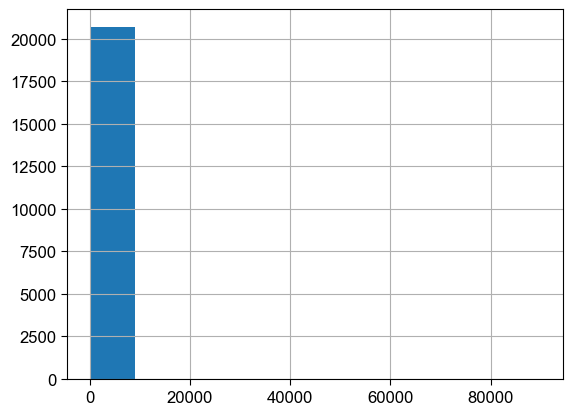

In [16]:
milanQ2.eur_price.hist()

<Axes: >

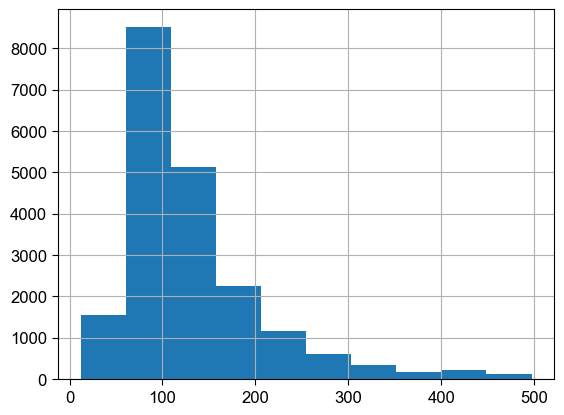

In [17]:
milanQ2[milanQ2['eur_price'] < 500].eur_price.hist()

In [18]:
# prices above 500 EUR are simply too extreme to predict
milanQ2 = milanQ2[milanQ2['eur_price'] <= 500]

I apply a 70%-30% train vs. hold-out split. This means a 14K observation training sample.

In [19]:
data_train, data_holdout = train_test_split(milanQ2, train_size=0.7, random_state=42)

### 1.2. Building predictive models

With the clean dataset at hand, we can now begin building models. I will build five predictive models:

1. simple OLS (trying different specifications with 5-fold cross-validation);
2. LASSO (starting from the most complex OLS specification);
3. Random Forest (with moderate tuning);
4. GBM (with minimal tuning);
5. XGBoost (with moderate tuning).

Note that the level of tuning for the last three models is mainly determined by the computational limitations of my computer.

First, I group my variables into certain categories to be able to easily construct variable sets.

In [20]:
basic_vars = ('f_property_type', 'f_room_type', 'n_accomodates', 'f_bathrooms', 'n_bedrooms', 'n_beds', 'n_distance_to_center', 'd_instant_bookable')
host_vars = ('n_host_since', 'f_host_location', 'f_host_response_time', 'p_host_response_rate', 'p_host_acceptance_rate', 'd_host_is_superhost',
             'd_hostverif_email', 'd_hostverif_phone', 'd_hostverif_work_email', 'd_host_has_profile_pic', 'd_host_identity_verified',
             'f_host_listings_count')
review_vars = ('f_number_of_reviews', 'n_days_since_first_rev', 'n_review_scores_rating', 'n_reviews_per_month', 'flag_n_days_since_first_rev',
              'flag_n_review_scores_rating', 'flag_n_reviews_per_month')
amenities = tuple([col for col in data_train if 'd_amenities_' in col])
poly_vars = tuple([col for col in data_train if col[0:2] in ['sq', 'cu']])

The below variables will be used to train RF, GBM and XGBoost models (thus no polynomials or interactions are specified).

In [21]:
predictors_ml = basic_vars + host_vars + review_vars + amenities

For the OLS models, I wanted to uncover some possible interaction terms. For this, I used a graphical approach. In code comments, I indicated whether I have deemed the graphical evidence strong enough to include a certain interaction term.

Note that I have tweaked the pre-written utility function a bit so that it can also be used to visualize factor-factor interactions.

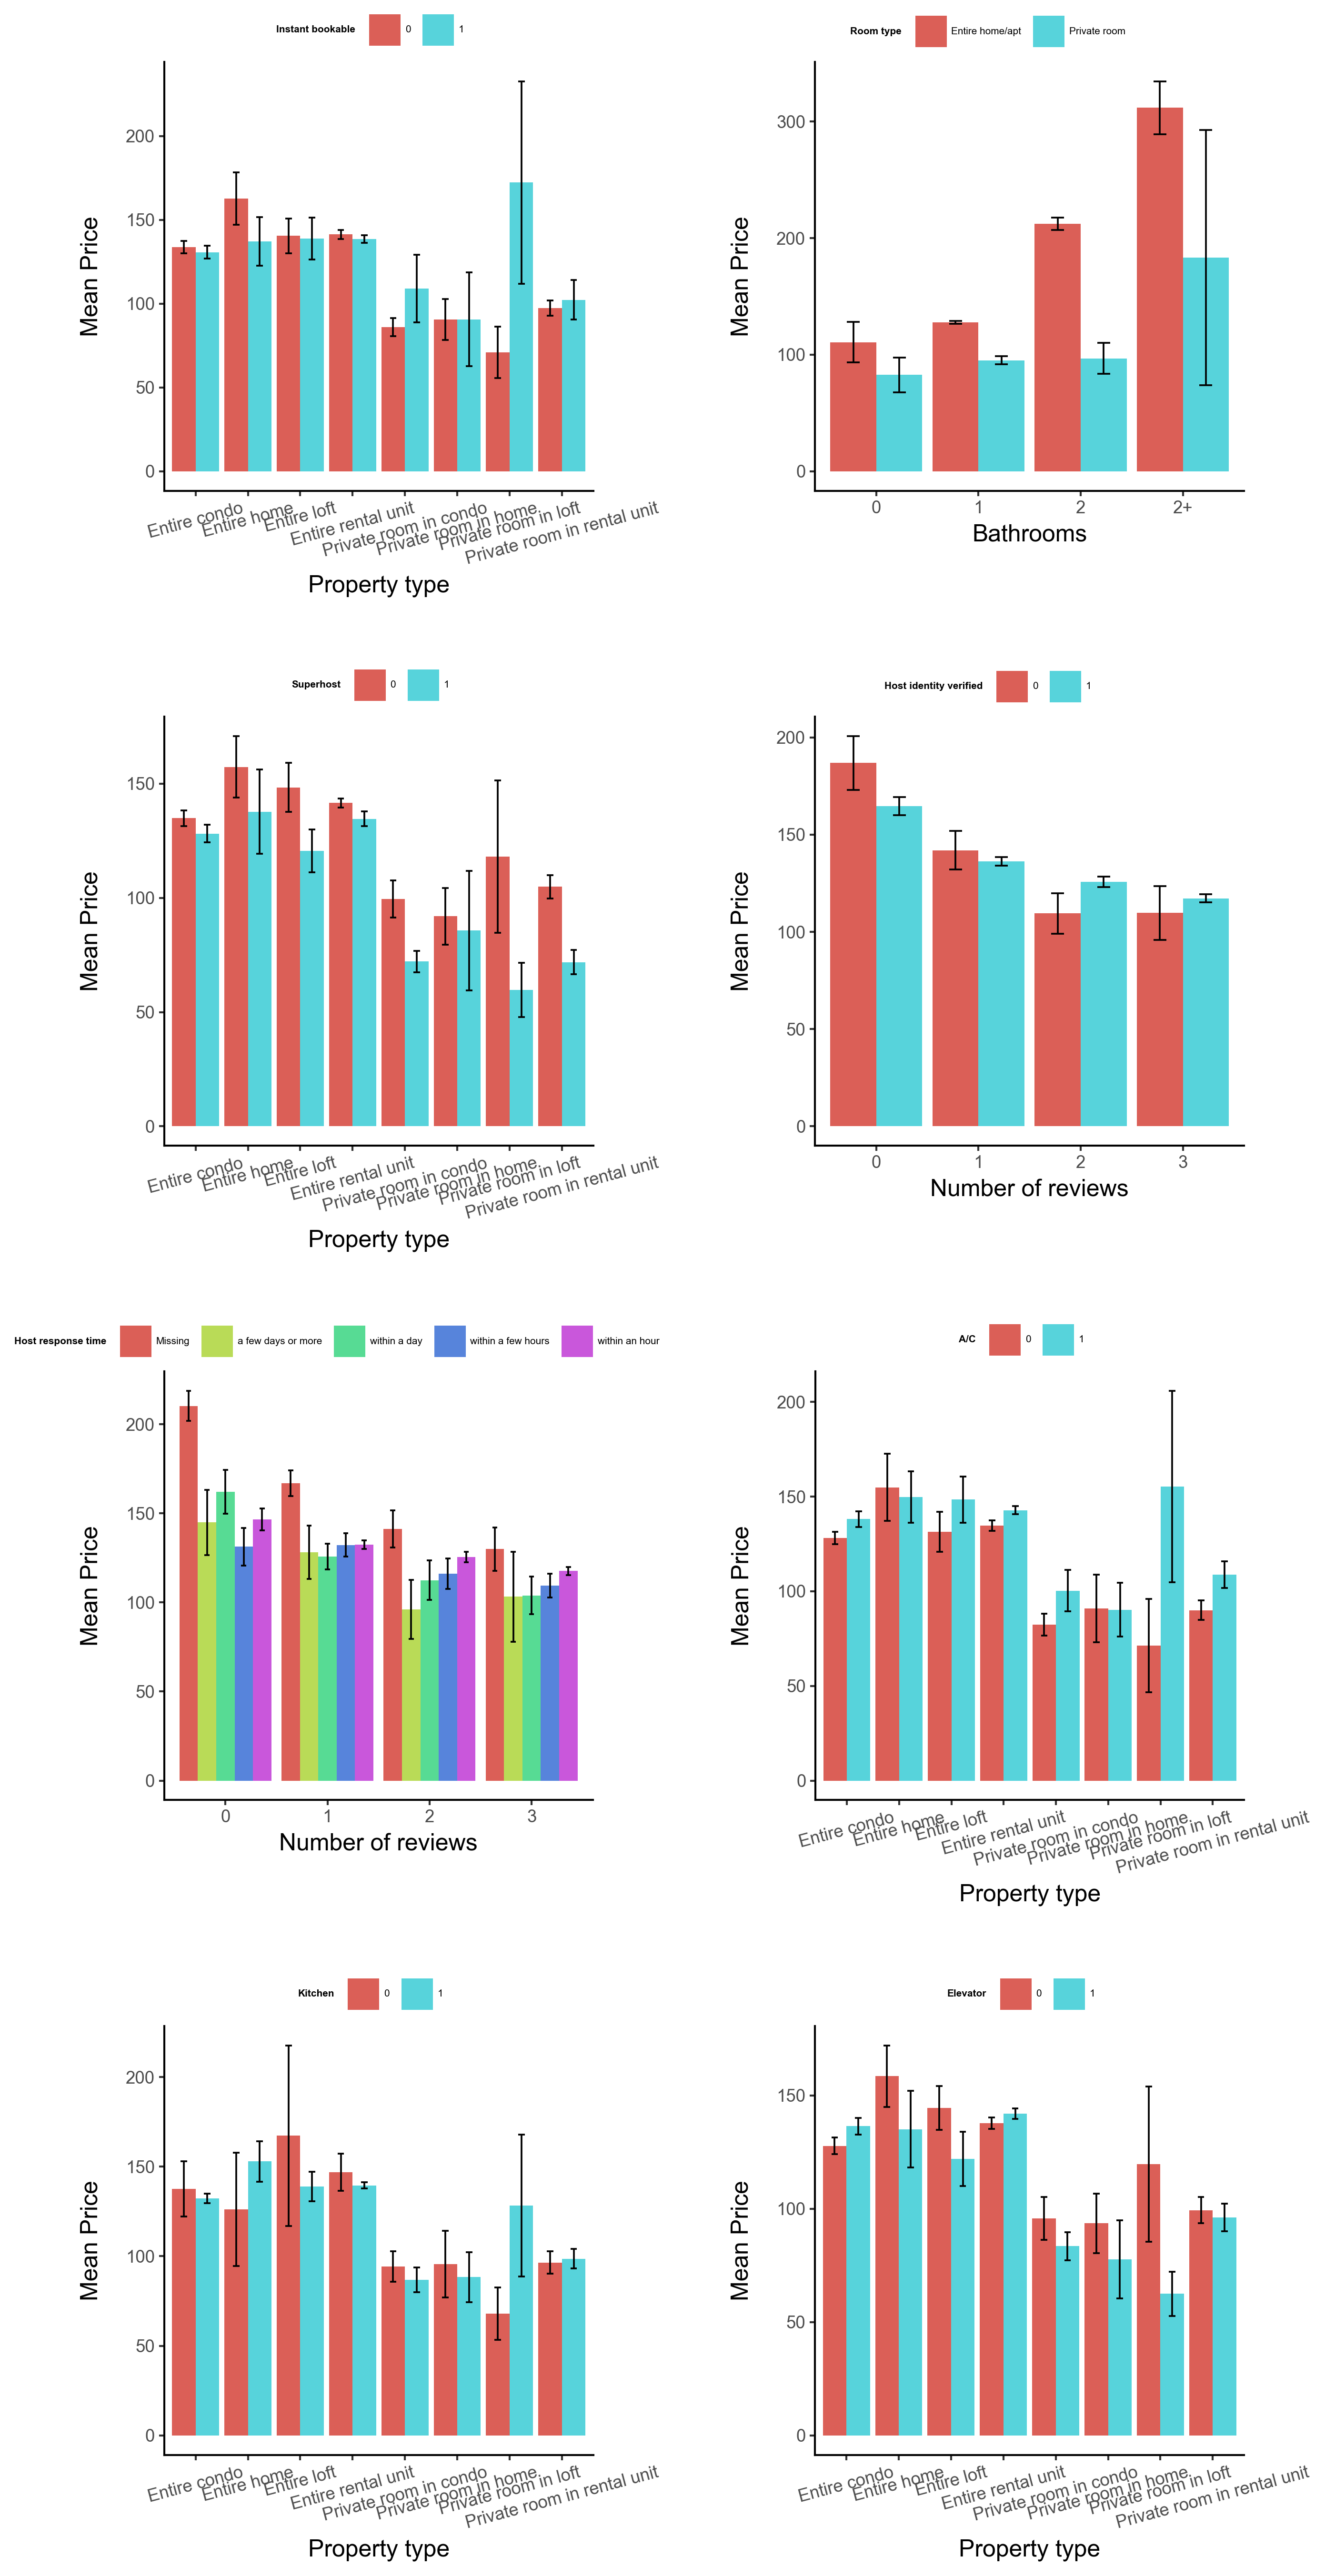

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [83]:
# interaction
p1 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_instant_bookable',
                        'Property type', 'Instant bookable') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p2 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_bathrooms', 'f_room_type',
                        'Bathrooms', 'Room type')

# no interaction
p3 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_host_is_superhost',
                        'Property type', 'Superhost') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p4 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'd_host_identity_verified',
                        'Number of reviews', 'Host identity verified')

# interaction
p5 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'f_host_response_time',
                        'Number of reviews', 'Host response time')

# interaction
p6 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_air_conditioning',
                        'Property type', 'A/C') + theme(axis_text_x=element_text(angle = 15))

# interaction
p7 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_kitchen',
                        'Property type', 'Kitchen') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p8 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_elevator',
                        'Property type', 'Elevator') + theme(axis_text_x=element_text(angle = 15))

g1 = pw.load_ggplot(p1, figsize=(3, 3))
g2 = pw.load_ggplot(p2, figsize=(3, 3))
g3 = pw.load_ggplot(p3, figsize=(3, 3))
g4 = pw.load_ggplot(p4, figsize=(3, 3))
g5 = pw.load_ggplot(p5, figsize=(3, 3))
g6 = pw.load_ggplot(p6, figsize=(3, 3))
g7 = pw.load_ggplot(p7, figsize=(3, 3))
g8 = pw.load_ggplot(p8, figsize=(3, 3))

interactions = (g1 | g2) / (g3 | g4 ) / (g5 | g6) / (g7 | g8)

display(interactions)

Having some interaction terms, we can now construct some OLS model equations in increasing complexity.

In [22]:
interaction_vars = ('f_property_type*d_instant_bookable', 'f_number_of_reviews*f_host_response_time',
                   'f_property_type*d_amenities_air_conditioning', 'f_property_type*d_amenities_kitchen')

In [23]:
ols_equations = [
    "~" + " + ".join(basic_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars),
    ("~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars) 
     + " + " + "(f_property_type + f_room_type + f_number_of_reviews) * (" + "+".join(amenities) + ")")
]

In [24]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

# NOTE: Running the model estimations takes a considerable amount of time. I recommend using only the pre-estimated results from the dill files (indicated in a further note).

The best OLS model is found through 5-fold cross-validation.

In [89]:
start_time = time()
cv_list = []
for model in ols_equations:
    cv_list += [ols_crossvalidator("eur_price" + model, data_train, 5, rstate = 1234)]
model_times = {
    'ols' : time() - start_time
}

Technically, the best model (by test RMSE) would be M5 - but instead, I have decided to work further with M4 instead, as its test RMSE is practically the same, but it is less complex.

In [91]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

Model  Coefficients  R-squared     BIC  Training RMSE  Test RMSE
0    M1            16       0.26  159462          68.76      68.85
1    M2            39       0.36  157591          63.83      64.07
2    M3            55       0.40  156897          61.92      62.32
3    M4            98       0.41  156955          61.13      61.77
4    M5           131       0.42  157063          60.67      61.45
5    M6           531       0.45  160211          59.05      62.34

Finally, I re-fitted the best model on the whole train sample.

In [93]:
y, X = dmatrices("eur_price" + ols_equations[3], data_train)
ols_model = LinearRegression().fit(X, y)

I also save into dill files my models, and the timing estimate to a JSON.

In [95]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "ols_model_cv.dill"), "wb") as f:
    dill.dump(cv_list, f)
with open(Path("model_dills", "ols_model.dill"), "wb") as f:
    dill.dump(ols_model, f)

Next, I fit a LASSO model, starting from the most complex equation (M6). I find the tuning parameter through cross-validation. Note that for proper results, I have to standardize my predictors. I will use the same scaler to standardize the hold-out and the live-data as well.

In [37]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True, random_state= 9876)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(0, 100, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
start_time = time()
lasso_model_cv.fit(X_scaled, y.ravel())
model_times['lasso'] = time() - start_time

I then save my results.

In [38]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "lasso_model.dill"), "wb") as f:
    dill.dump(lasso_model_cv.best_estimator_, f)
with open(Path("model_dills", "lasso_model_cv.dill"), "wb") as f:
    dill.dump(lasso_model_cv, f)

The next model is a Random Forest. I set n-estimators to 250, and include moderate tuning.

In [103]:
rfr = RandomForestRegressor(
    random_state=485,
    criterion="squared_error",
    n_estimators=250,
    oob_score=True,
    n_jobs=7,
)

tune_grid = {"max_features": [8, 10, 12, 14, 16], "min_samples_split": [3, 5, 10, 15]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0
)

y, X = dmatrices("eur_price ~ " + " + ".join(predictors_ml), data_train)

start_time = time()
rf_model_cv = rf_random.fit(X, y.ravel())
model_times['rf'] = time() - start_time

The results are then saved.

In [105]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "rf_model.dill"), "wb") as f:
    dill.dump(rf_model_cv.best_estimator_, f)
with open(Path("model_dills", "rf_model_cv.dill"), "wb") as f:
    dill.dump(rf_model_cv, f)

The first boosting model is a GBM one. I could only provide very simple tuning to avoid computational issues.

In [108]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, random_state = 31)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose = False
)

start_time = time()
gbm_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['gbm'] = timespan

I again save the results.

In [117]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "gbm_model.dill"), "wb") as f:
    dill.dump(gbm_model_cv.best_estimator_, f)
with open(Path("model_dills", "gbm_model_cv.dill"), "wb") as f:
    dill.dump(gbm_model_cv, f)

The final model is an XGBoost regression with moderate tuning.

In [25]:
xgb = XGBRegressor(
    tree_method="hist", 
    objective="reg:squarederror",
    random_state = 56
)

tune_grid = {
    "n_estimators": [250, 350, 450],  
    "max_depth": [3, 6, 9],  
    "colsample_bytree": [0.6, 0.8, 1.0],   
    "learning_rate": [0.05, 0.1],
    "min_child_weight": [10, 20]
}

xgb_model_cv = GridSearchCV(
    xgb, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

xgb_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", xgb_model_cv)], verbose = False
)

start_time = time()
xgb_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['xgb'] = timespan

I save these results as well.

In [27]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "xgb_model.dill"), "wb") as f:
    dill.dump(xgb_model_cv.best_estimator_, f)
with open(Path("model_dills", "xgb_model_cv.dill"), "wb") as f:
    dill.dump(xgb_model_cv, f)

Add files to an archive so that they can be pushed to GitHub.

In [39]:
files_to_zip = [Path("model_dills", "ols_model_cv.dill"), Path("model_dills", "ols_model.dill"),
               Path("model_dills", "lasso_model.dill"), Path("model_dills", "lasso_model_cv.dill"),
               Path("model_dills", "rf_model.dill"), Path("model_dills", "rf_model_cv.dill"),
               Path("model_dills", "gbm_model.dill"), Path("model_dills", "gbm_model_cv.dill"),
               Path("model_dills", "xgb_model.dill"), Path("model_dills", "xgb_model_cv.dill")]

zip_filename = 'model_dills.zip'

with zipfile.ZipFile(zip_filename, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
    for file in files_to_zip:
        zipf.write(file, arcname=file.name)

# Note: Running the code from here, you only import the pre-estimated models stored in dill files.
### 1.3. Model comparison and discussion

First, we have to load the saved models from the dill files.

In [40]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

Extract archived model dills.

In [41]:
with zipfile.ZipFile("model_dills.zip","r") as zip_ref:
    zip_ref.extractall("model_dills")

In [118]:
with open(Path("model_dills", "ols_model.dill"), "rb") as f:
    ols = dill.load(f)
with open(Path("model_dills", "lasso_model.dill"), "rb") as f:
    lasso = dill.load(f)
with open(Path("model_dills", "rf_model.dill"), "rb") as f:
    rf = dill.load(f)
with open(Path("model_dills", "gbm_model.dill"), "rb") as f:
    gbm = dill.load(f)
with open(Path("model_dills", "xgb_model.dill"), "rb") as f:
    xgb = dill.load(f)

In [119]:
with open(Path("model_dills", "ols_model_cv.dill"), "rb") as f:
    ols_cv = dill.load(f)
with open(Path("model_dills", "lasso_model_cv.dill"), "rb") as f:
    lasso_cv = dill.load(f)
with open(Path("model_dills", "rf_model_cv.dill"), "rb") as f:
    rf_cv = dill.load(f)
with open(Path("model_dills", "gbm_model_cv.dill"), "rb") as f:
    gbm_cv = dill.load(f)
with open(Path("model_dills", "xgb_model_cv.dill"), "rb") as f:
    xgb_cv = dill.load(f)

First, let's take a closer look at the training outputs! For the OLS models, we have already seen this table and concluded that M4 is the best model as it only has a marginally worse test RMSE then M5, but it is significantly less complex.

In [120]:
compare_model_fits = (
    pd.DataFrame(ols_cv)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(ols_cv))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

Model  Coefficients  R-squared     BIC  Training RMSE  Test RMSE
0    M1            16       0.26  159462          68.76      68.85
1    M2            39       0.36  157591          63.83      64.07
2    M3            55       0.40  156897          61.92      62.32
3    M4            98       0.41  156955          61.13      61.77
4    M5           131       0.42  157063          60.67      61.45
5    M6           531       0.45  160211          59.05      62.34

For the LASSO model, I plotted the cross-validated test RMSE as a function of the alpha tuning parameter. From the chart it seems that the grid search could find a local minimum point - though this does not mean that this is the most optimal parameter. Also note that the LASSO model produced a very similar test RMSE to our chosen simple OLS model.

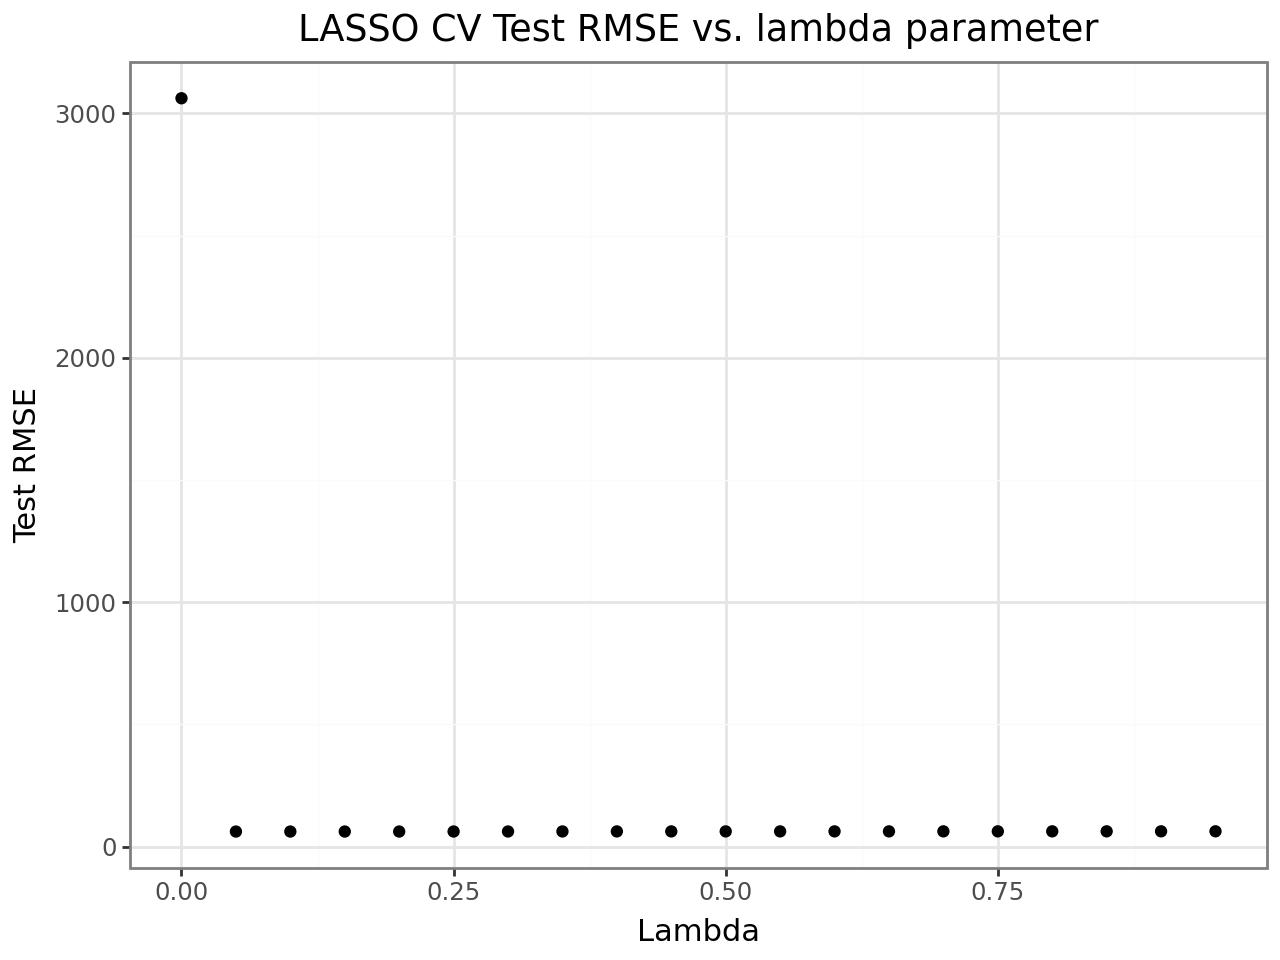

In [121]:
lasso_tuning = pd.DataFrame({'Lambda' : lasso_cv.cv_results_['param_alpha'].data, 'Test RMSE' : lasso_cv.cv_results_['mean_test_score']*-1})
(
    ggplot(lasso_tuning, aes('Lambda', 'Test RMSE')) + geom_point() + theme_bw() + labs(title = 'LASSO CV Test RMSE vs. lambda parameter')
)

The above chart is rather uninformative: I exclude lambda = 0.

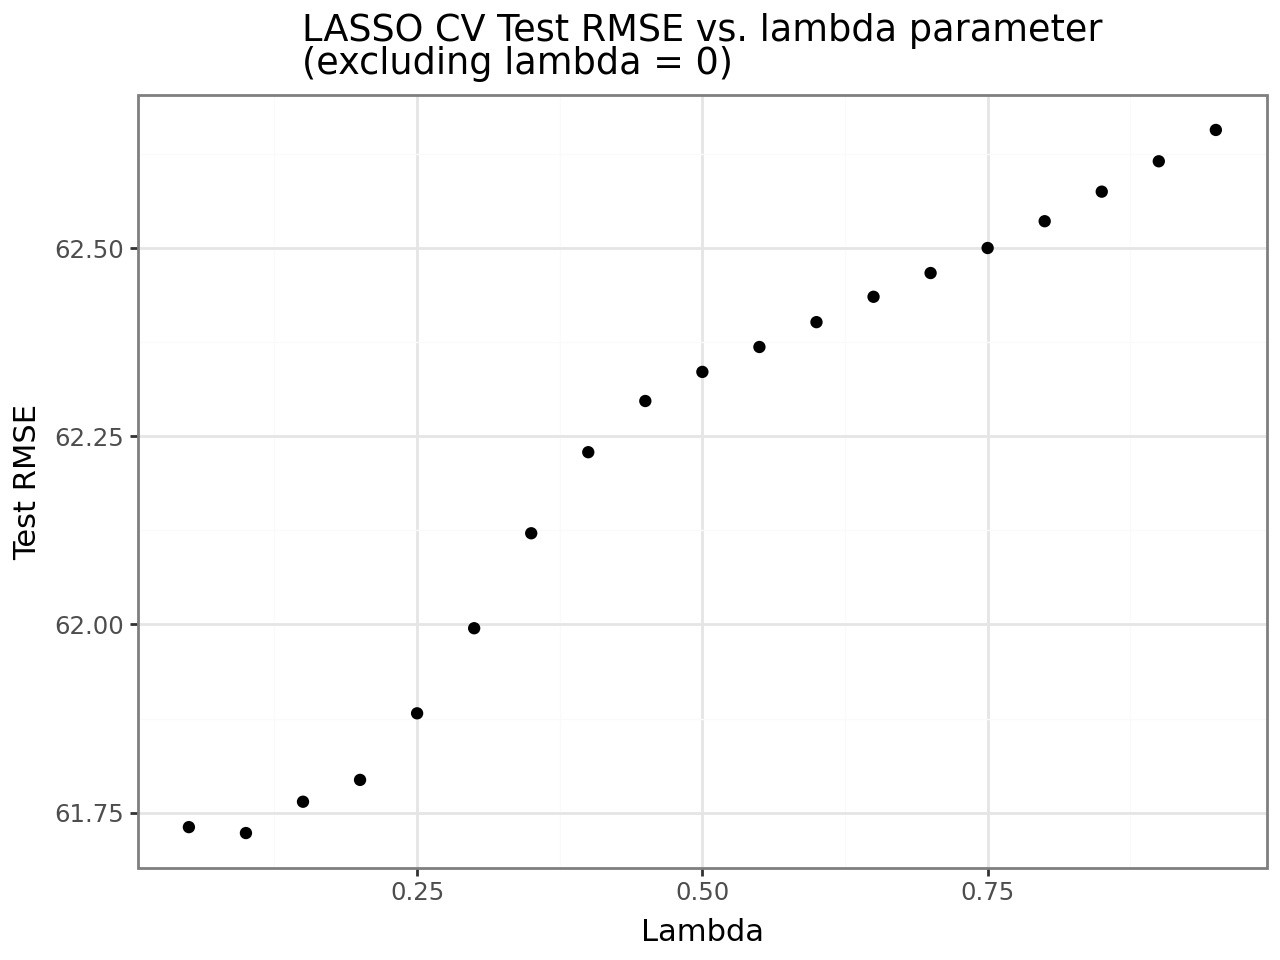

In [122]:
(
    ggplot(lasso_tuning.iloc[1:,:], aes('Lambda', 'Test RMSE'))
    + geom_point()
    + theme_bw()
    + labs(title = 'LASSO CV Test RMSE vs. lambda parameter\n(excluding lambda = 0)')
)

Now let's take a look at the Random Forest tuning grid! As we have two hyperparameters now, I visualized the cross-validated test RMSE values on a heatmap. It seems from the chart that the grid may have been misspecified, as the minimal RMSE value is at the top right corner, indicating that it may have been beneficial to include smaller minimum samples split and larger maximum features values in the tuning grid. However, partly due to computational constraints, and partly because - as we will see - this is already a pretty good model, I will go with the hyperparameters found by this grid search.

Also note, that the Random Forest outperforms both the OLS and the LASSO models (as expected).

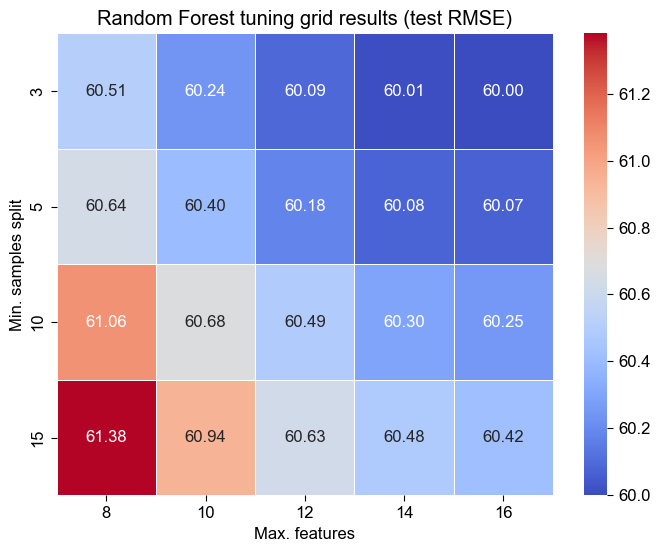

In [123]:
heatmap_data = pd.DataFrame(rf_cv.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel("Max. features")
plt.ylabel("Min. samples split")
plt.title("Random Forest tuning grid results (test RMSE)")

plt.show()

For the GBM model, the tuning grid indicates that the optimal hyperparameter set-up is indeed a local minimum for the maximum depth, but it may have been beneficial to add lower number of estimators to the gridsearch. However, we might have been able to achieve even better results using a more granular grid. Again, for computational reasons, I will go with this lightly tuned model, as it already outperforms the previous three models.

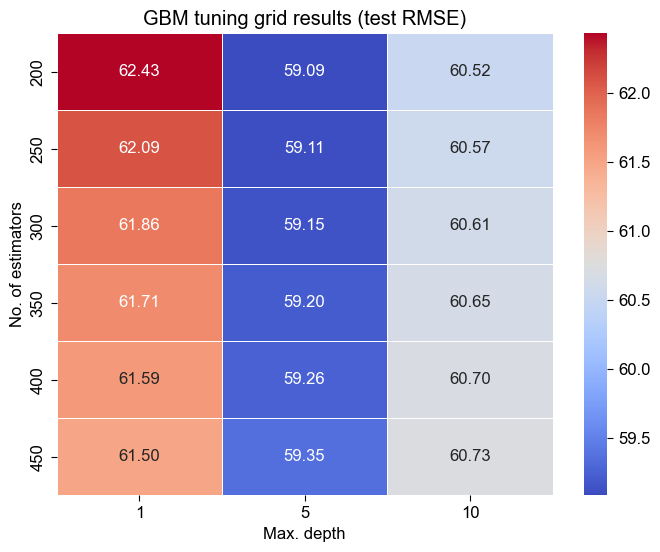

In [124]:
df = pd.DataFrame(gbm_cv.cv_results_)[
    ["param_max_depth", "param_n_estimators", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1
).pivot(
    index="param_n_estimators", columns="param_max_depth", values="mean_test_score"
)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Max. depth")
plt.ylabel("No. of estimators")
plt.title("GBM tuning grid results (test RMSE)")
plt.show()


For the XGBoost model, the tuning grid consisted of 6 hyperparameters, so I could not visualize these on a simple heatmap. What I did instead is that I simply listed out the best and worst performing 10 models according to the cross-validated test RMSE. What we can see is that for most of the tuning parameters, the optimal value was found at one endpoint of the provided range, so again, a more extended tuning may have been beneficial. Note however, that even with this tuning, the XGBoost already outperforms the GBM model.

In [125]:
df = pd.DataFrame(xgb_cv.cv_results_)[[
    "mean_test_score",
    "param_colsample_bytree",
    "param_learning_rate",
    "param_max_depth",
    "param_min_child_weight",
    "param_n_estimators"
]].astype(float).round(2)

df.mean_test_score = df.mean_test_score * -1

df.sort_values(by = 'mean_test_score', ascending = True, inplace = True)

df.columns = ['Test RMSE', 'Col. subsample ratio', 'Learning rate', 'Max. depth', 'Min. child weight', 'No. of estimators']

df.reset_index(drop = True, inplace = True)

In [126]:
df.head(10)

Test RMSE  Col. subsample ratio  Learning rate  Max. depth  \
0      58.57                   0.6           0.05         6.0   
1      58.58                   0.6           0.05         6.0   
2      58.63                   0.6           0.05         9.0   
3      58.64                   0.6           0.05         9.0   
4      58.65                   0.6           0.05         6.0   
5      58.66                   0.6           0.05         6.0   
6      58.67                   0.6           0.05         9.0   
7      58.71                   0.6           0.05         9.0   
8      58.71                   0.6           0.05         9.0   
9      58.73                   0.8           0.05         9.0   

   Min. child weight  No. of estimators  
0               10.0              450.0  
1               20.0              450.0  
2               20.0              350.0  
3               20.0              250.0  
4               10.0              350.0  
5               20.0              350.0  
6               20.0              450.0  
7               10.0              350.0  
8               10.0              250.0  
9               20.0              350.0

In [127]:
df.tail(10)

Test RMSE  Col. subsample ratio  Learning rate  Max. depth  \
98       59.95                   1.0           0.10         9.0   
99       59.98                   1.0           0.05         3.0   
100      60.08                   1.0           0.10         9.0   
101      60.12                   1.0           0.10         9.0   
102      60.13                   0.6           0.05         3.0   
103      60.19                   0.6           0.05         3.0   
104      60.24                   0.8           0.05         3.0   
105      60.25                   0.8           0.05         3.0   
106      60.29                   1.0           0.05         3.0   
107      60.30                   1.0           0.05         3.0   

     Min. child weight  No. of estimators  
98                10.0              350.0  
99                20.0              350.0  
100               10.0              450.0  
101               20.0              450.0  
102               20.0              250.0  
103               10.0              250.0  
104               10.0              250.0  
105               20.0              250.0  
106               10.0              250.0  
107               20.0              250.0

To evaluate the model's performance on unseen data, we should re-estimate all of them (with the cross-validated tuning parameters) on the whole train sample (to utilize all available information). Note that we have already done this for the OLS model, so we should only deal with the other four. For easier use later, I incorporate the models into some pipelines.

In [128]:
categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [129]:
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
scaler.fit(X)
lasso_best_pipeline = Pipeline(
    [
        ("scale", scaler),
        ("regressor", lasso),
    ]
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train) # dmatrices does the categorical encoding, so no need for the onehotencoder
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1, random_state=9876))])

In [130]:
rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf),
    ]
)
rf_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [131]:
gbm_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", gbm),
    ]
)
gbm_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=200,
                                           random_state=31))])

In [132]:
xgb_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", xgb),
    ]
)
xgb_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

Having refitted the models on the whole training set, we can now evaluate their performance on unseen data. For this, I make a prediction on the hold-out set with all of the models, than calculate the RMSE values of these predictions.

In [133]:
hold_out_rmse = {}

In [134]:
y, X = dmatrices("eur_price" + ols_equations[3], data_holdout)
hold_out_rmse['ols'] = mean_squared_error(y, ols.predict(X), squared = False)

In [135]:
y, X = dmatrices("eur_price" + ols_equations[5], data_holdout)
hold_out_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)

In [136]:
hold_out_rmse['rf'] = mean_squared_error(data_holdout['eur_price'], rf_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [137]:
hold_out_rmse['gbm'] = mean_squared_error(data_holdout['eur_price'], gbm_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [138]:
hold_out_rmse['xgb'] = mean_squared_error(data_holdout['eur_price'], xgb_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

Now that we have both training time and RMSE data (both for the hold-out sample and the cross-validated test RMSE), let's create a horserace chart! Note that I included an adjusted time column as well, as the OLS and LASSO models have not been estimated on multiple cores. Thus I included an adjustment for them, assuming 80% parallelization efficiency, so that the timing values become comparable.

Note: taking the max of the test scores, as these are negative values.

In [139]:
cv_test_rmse = {
    'ols' : pd.DataFrame(ols_cv)['Test RMSE'].iloc[3],
    'lasso' : lasso_cv.cv_results_['mean_test_score'].max()*-1,
    'rf' : rf_cv.cv_results_['mean_test_score'].max()*-1,
    'gbm' : gbm_cv.cv_results_['mean_test_score'].max()*-1,
    'xgb' : xgb_cv.cv_results_['mean_test_score'].max()*-1,
}

In [140]:
horserace = pd.DataFrame({
    'CV test RMSE' : cv_test_rmse,
    'Hold-out set RMSE': hold_out_rmse,
    'Training time (m)': model_times
})

def adjust_for_parallelization(time, num_cores=8, efficiency=0.8):
    return time / (num_cores * efficiency + (1 - efficiency))

horserace['Adj. training time (assuming all cores used, m)'] = horserace['Training time (m)']
horserace.loc[['ols', 'lasso'], 'Adj. training time (assuming all cores used, m)'] = horserace.loc[['ols', 'lasso'], 'Training time (m)'].apply(adjust_for_parallelization)
horserace.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

horserace['CV test RMSE'] = round(horserace['CV test RMSE'], 2)
horserace['Hold-out set RMSE'] = round(horserace['Hold-out set RMSE'], 2)
horserace['Training time (m)'] = round(horserace['Training time (m)'] / 60, 2)
horserace['Adj. training time (assuming all cores used, m)'] = round(horserace['Adj. training time (assuming all cores used, m)'] / 60, 2)

What we can deduce from the below horserace table is the following:

- Hold-out set RMSE values are very similar to CV test RMSE values for all models (for OLS and LASSO, they are marginally larger, while for the tree-based methods, they are marginally smallar) - all in all, this suggests that the models are not overfitted to the training data;
- The hold-out RMSE decreases the more complex the chosen model is (as expected) - this results in the XGBoost model being the best in terms of hold-out RMSE;
- There is a very apparent trade-off between model complexity and training time. However, the GBM model's training time is very extreme, suggesting it may not be worth to use it, as we have similarly good models with only the fraction of the training time;
- If we are willing to sacrafice on interpretability, then the Random Forest and the XGBoost models could be our choice.

Thus, I will further analyze in the next section the Random Forest and the XGBoost models.

In [141]:
horserace

CV test RMSE  Hold-out set RMSE  Training time (m)  \
OLS                   61.77              62.67               0.24   
LASSO                 61.72              62.22               3.66   
Random Forest         60.00              59.70               5.43   
GBM                   59.09              58.98              18.61   
XGBoost               58.57              58.17               4.49   

               Adj. training time (assuming all cores used, m)  
OLS                                                       0.04  
LASSO                                                     0.55  
Random Forest                                             5.43  
GBM                                                      18.61  
XGBoost                                                   4.49

### 1.4. Analysis of Random Forest and XGBoost models

To analyze and somewhat understand the Random Forest and XGBoost models, I first draw up some variable importance plots. Importantly, I calculate grouped importance values for factor variables. **Note that running the `permutation_importance` function calls takes a few minutes.**

I present plots showing all variables above a 1% importance cutoff, and also separately only the top 10 most important variables.

In [77]:
result = permutation_importance(
    rf_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [78]:
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [79]:
rf_varimp_plot_all = (
    ggplot(
        grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

rf_varimp_plot_top = (
    ggplot(
        grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

In [80]:
xgb_result = permutation_importance(
    xgb_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [81]:
xgb_grouped_imp = (
    pd.DataFrame(xgb_result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [82]:
xgb_varimp_plot_all = (
    ggplot(
        xgb_grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

xgb_varimp_plot_top = (
    ggplot(
        xgb_grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

Looking at the variable importance plots, we can see that both models have found more or less the same variables the most important. This is best illustrated by the fact that for the top 10 most important variables, 8 of them are common between the two models.

An important difference between the two models is that the Random Forest's variable importance is more balanced than the XGBoost's. By this I mean that the XGBoost model puts a lot of importance on e.g. the distance to center variable (almost 25%), and as a result, the other features become less important. In comparison, the Random Forest's decline in variable importances is less steep.

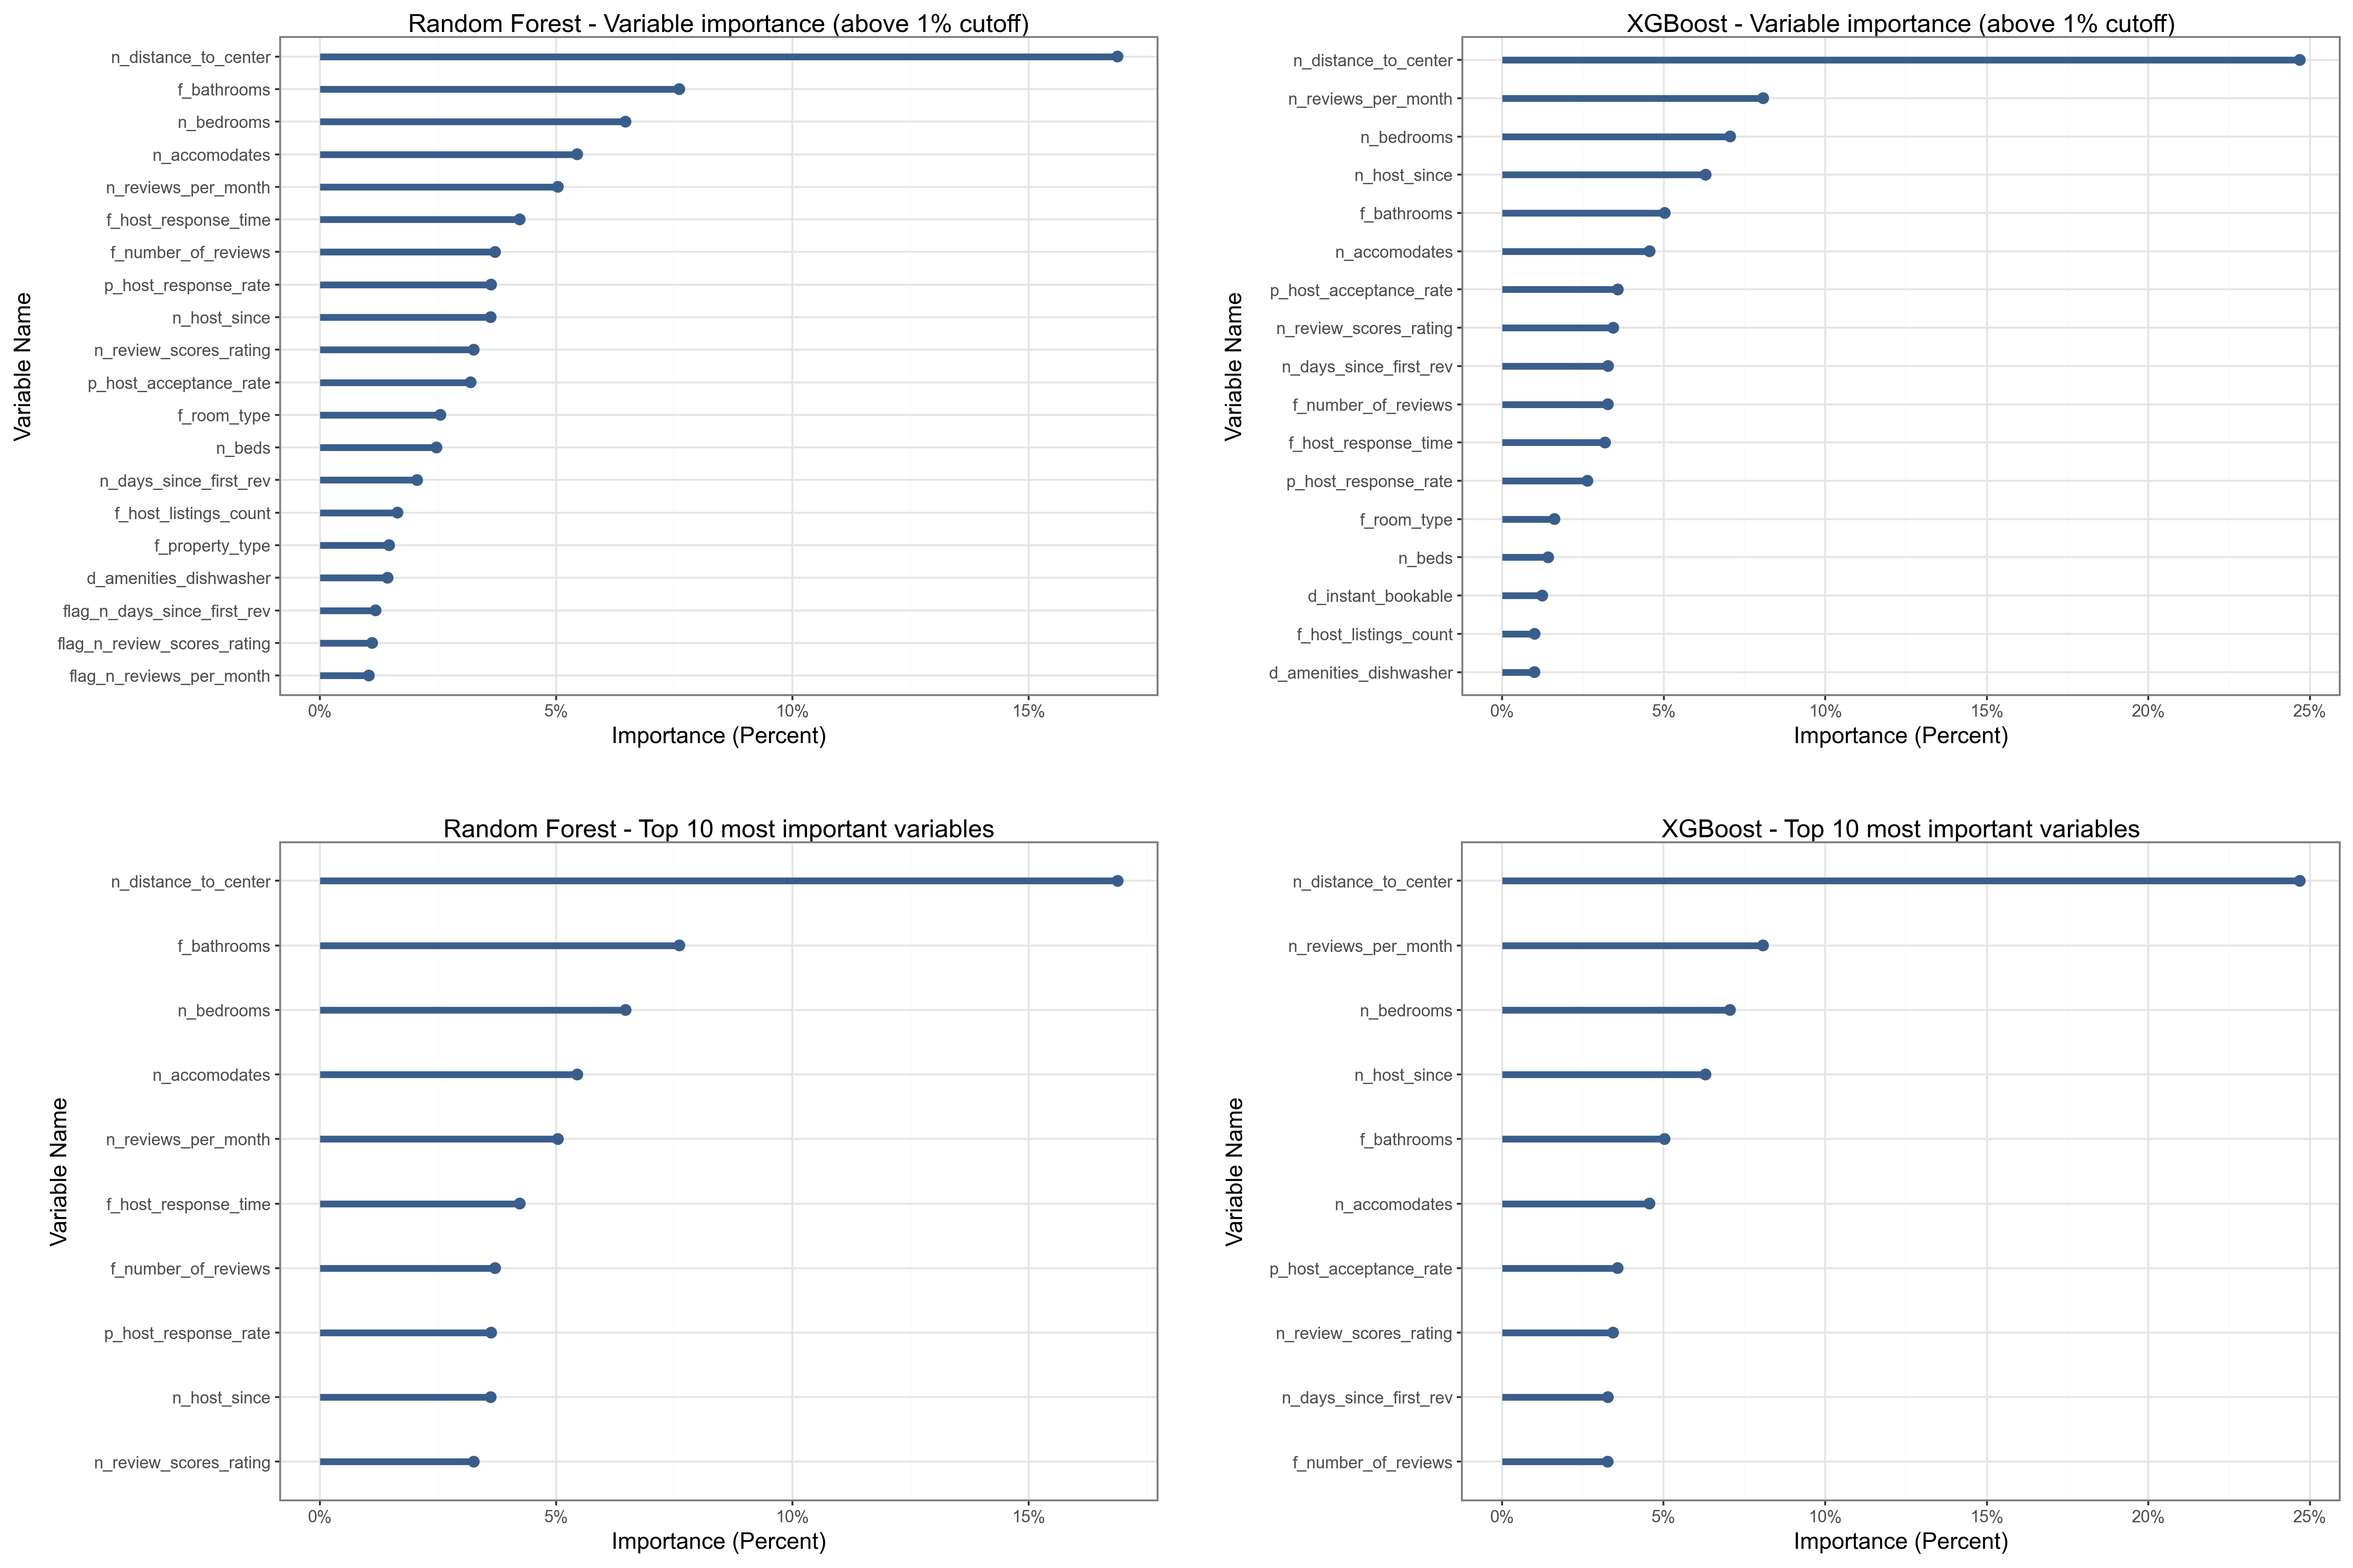

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [83]:
pw.basefigure.clear()
display((pw.load_ggplot(rf_varimp_plot_all) | pw.load_ggplot(xgb_varimp_plot_all)) / ((pw.load_ggplot(rf_varimp_plot_top) | pw.load_ggplot(xgb_varimp_plot_top))))

To go deeper into the most important variables, I show a partial dependence plot for each model's top 5 variables. For this, I mainly use the SHAP package (except for categorical variables, for which I use `sklearn`'s `partial_dependence`). As the codes generating the plots are rather long, I wrapped it inside a function.

In [142]:
def plot_partial_dependence_comparison(feature, data_holdout, pipeline1, pipeline2, fig1_title, fig2_title):
    fig1, ax1 = shap.partial_dependence_plot(
        feature,
        pipeline1.predict,
        data_holdout,
        model_expected_value=False,
        feature_expected_value=False,
        ice=False,
        show=False
    )
    plt.close()

    fig2, ax2 = shap.partial_dependence_plot(
        feature,
        pipeline2.predict,
        data_holdout,
        model_expected_value=False,
        feature_expected_value=False,
        ice=False,
        show=False
    )
    plt.close()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    fig1.canvas.draw()
    fig2.canvas.draw()

    axes[0].imshow(fig1.canvas.buffer_rgba())
    axes[1].imshow(fig2.canvas.buffer_rgba())

    for ax in axes:
        ax.axis("off")

    axes[0].set_title(fig1_title)
    axes[1].set_title(fig2_title)
    
    plt.tight_layout()
    plt.show()


**`n_distance_to_center` - \#1 for both models**

For the distance to center, both models suggest a non-linear, negative pattern. An interesting difference is that the Random Forest seems more smooth, whereas the XGBoost is quite spiky. This may indicate that the latter model is somewhat overfitted as it may have learned some patterns that were actually just noise in the data. Nonetheless, both plots suggest that listings further away from the center are less and less expensive. Importantly, both models have a slight up-turn around 8 kilometers - this may just due to the low number of observations at that range.

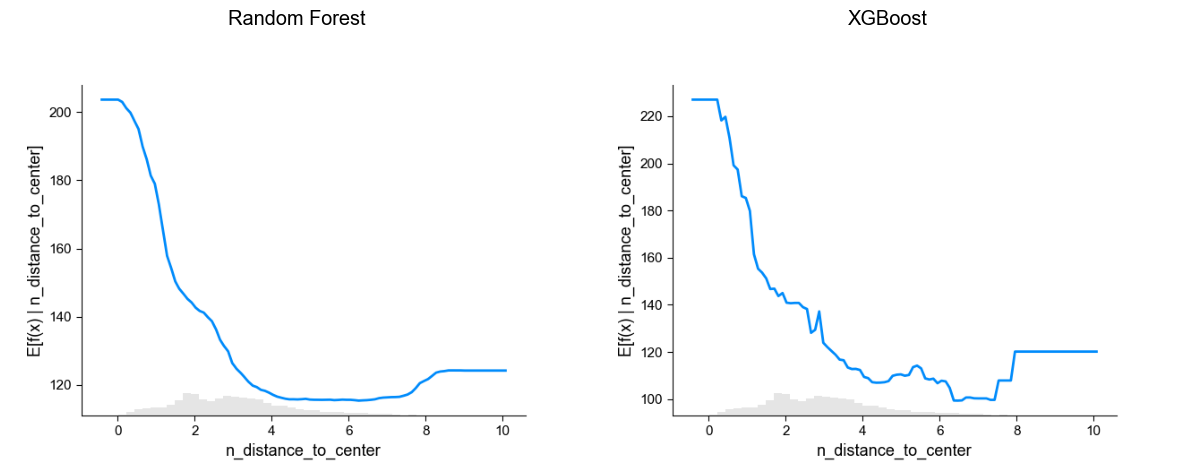

In [143]:
plot_partial_dependence_comparison('n_distance_to_center', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_reviews_per_month` - \#5 for RF, \#2 for XGBoost**

As for the number of reviews per month, both models suggest a steeply declining relationship, which turns into practically 0 after around 10 reviews per month. Once again, the XGBoost chart is more ridged than the Random Forest.

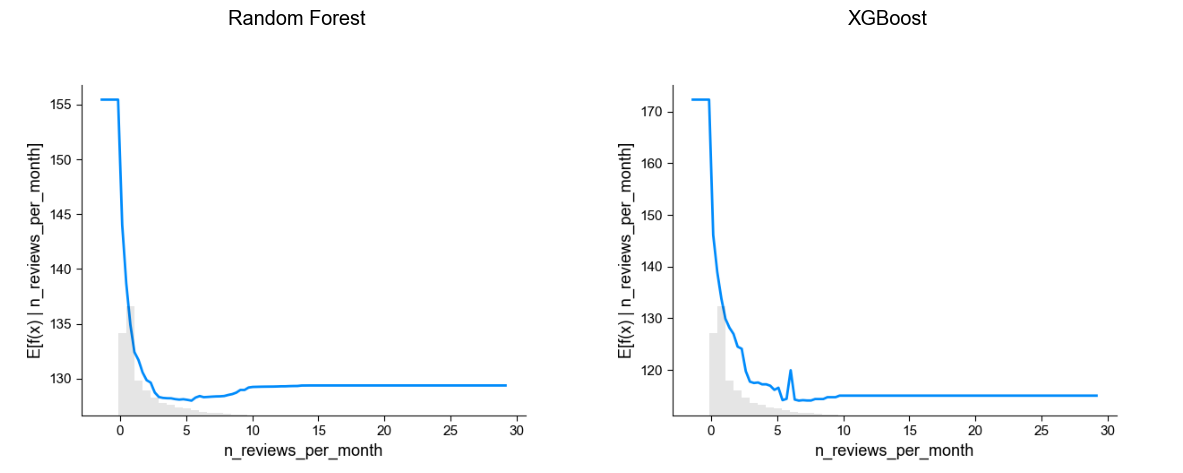

In [144]:
plot_partial_dependence_comparison('n_reviews_per_month', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`f_bathrooms` - \#2 for RF, \#5 for XGBoost**

Concerning the number of bathrooms, both models suggest that listings with more bathrooms are generally more expensive, though the exact price difference between bathroom count categories is different for the two models. Interestingly though, listings with no bathrooms are priced higher by both models than those with at least 1 bathroom. This latter observation may tell us that actually, observations with 0 bathrooms were rather indicating missing or erronous data points.

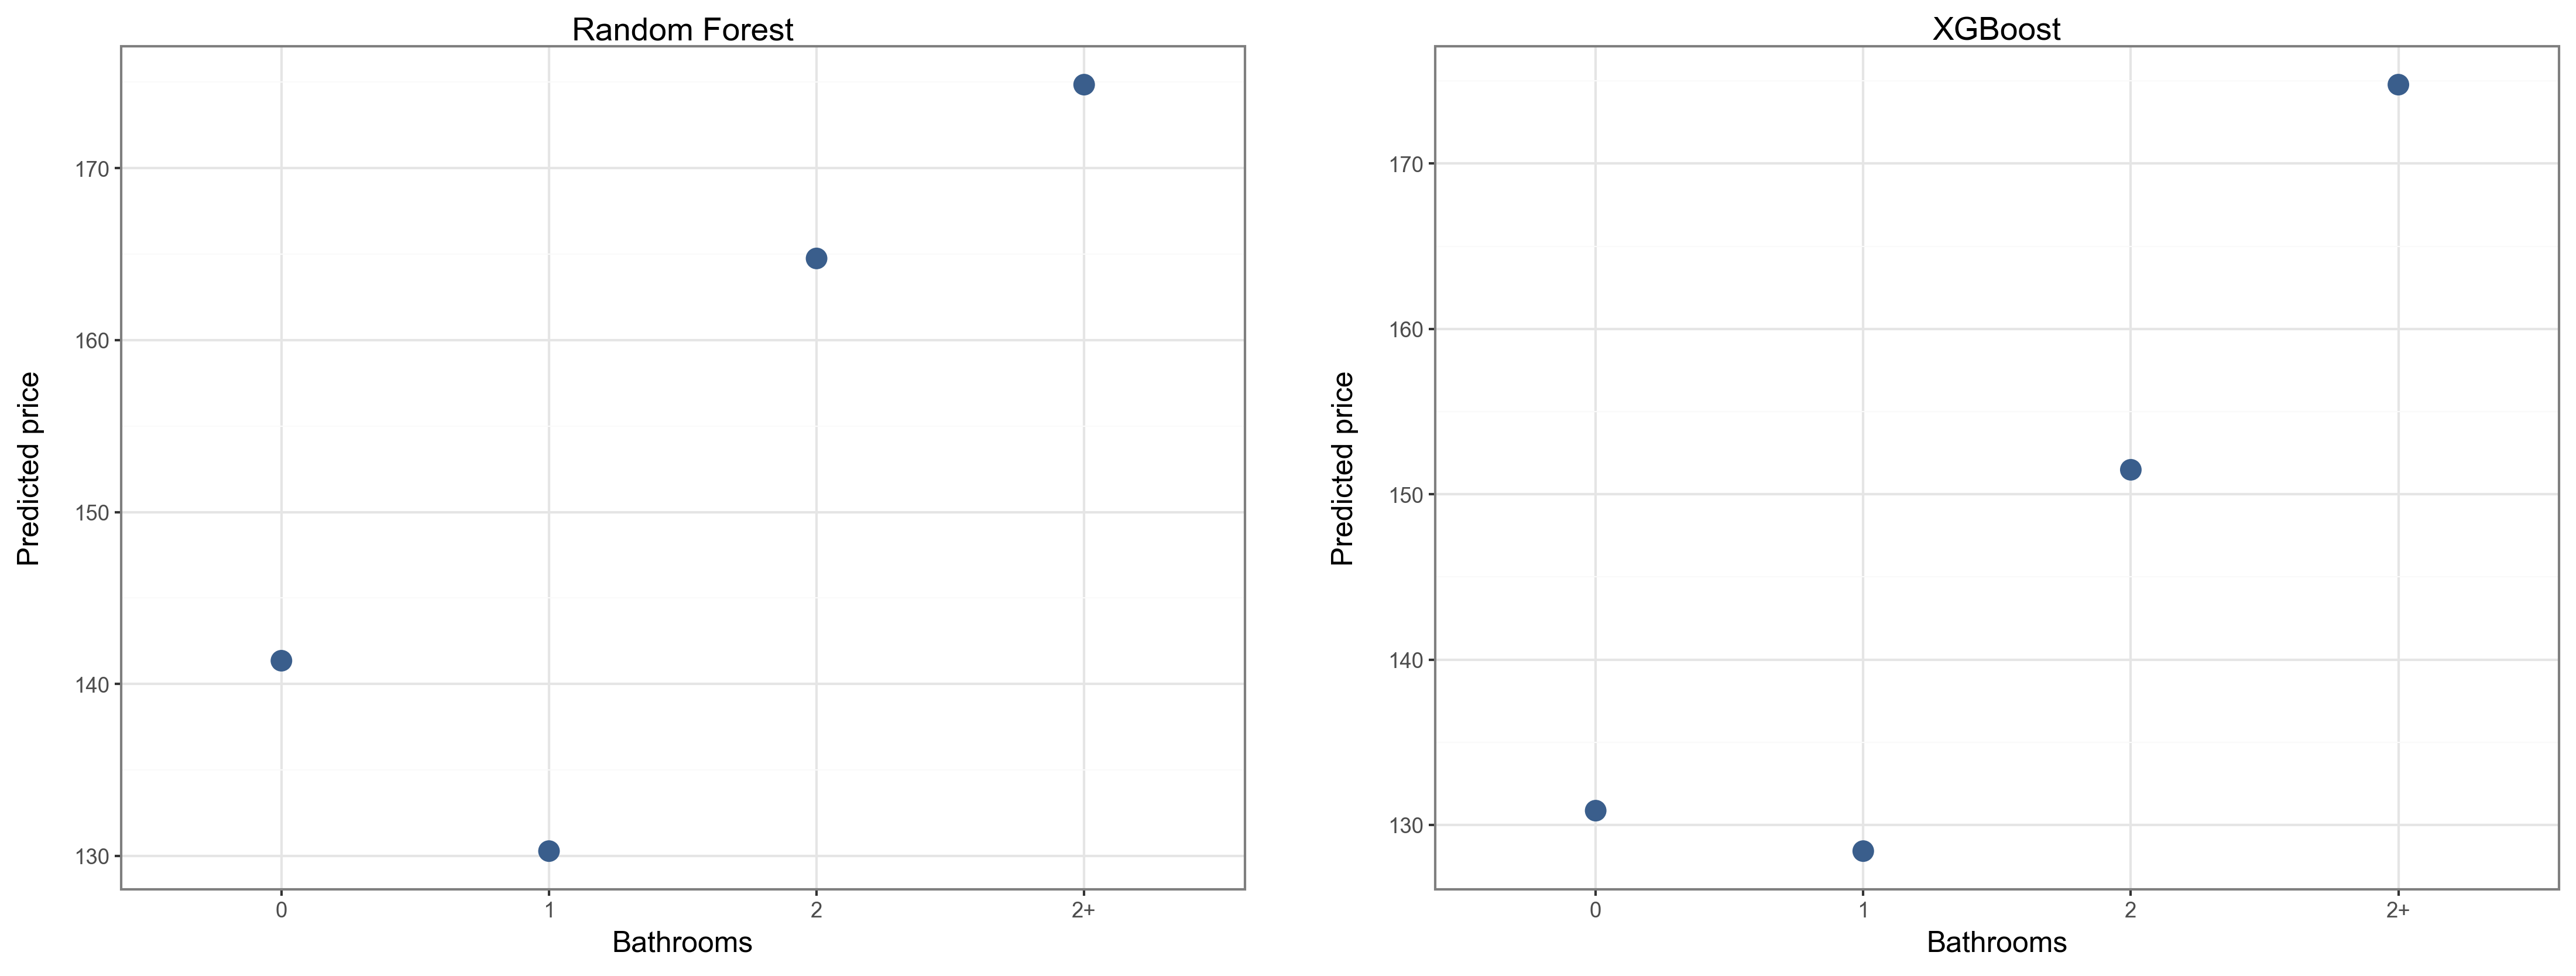

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [145]:
pw.basefigure.clear()
rf_bathroom_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[list(predictors_ml)], ["f_bathrooms"], kind="average"
)

rf_bathroom_pdp = (
    pd.DataFrame(rf_bathroom_pdp["average"], columns=rf_bathroom_pdp["grid_values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)

p1 = (
    ggplot(rf_bathroom_pdp, aes(x="Bathrooms", y="Predicted price"))
    + geom_point(color=color[0], size=4)
    + theme_bw()
    + labs(title = 'Random Forest')
)

xgb_bathroom_pdp = partial_dependence(
    xgb_best_pipeline, data_holdout[list(predictors_ml)], ["f_bathrooms"], kind="average"
)

xgb_bathroom_pdp = (
    pd.DataFrame(xgb_bathroom_pdp["average"], columns=xgb_bathroom_pdp["grid_values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)

p2 = (
    ggplot(xgb_bathroom_pdp, aes(x="Bathrooms", y="Predicted price"))
    + geom_point(color=color[0], size=4)
    + theme_bw()
    + labs(title = 'XGBoost')
)

display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

**`n_bedrooms` - \#3 for both models**

The relationship between price and the number of bedrooms looks very similar for both models, suggesting that an increased number of bedrooms is associated with a higher price, with the price difference between each step not being equal.

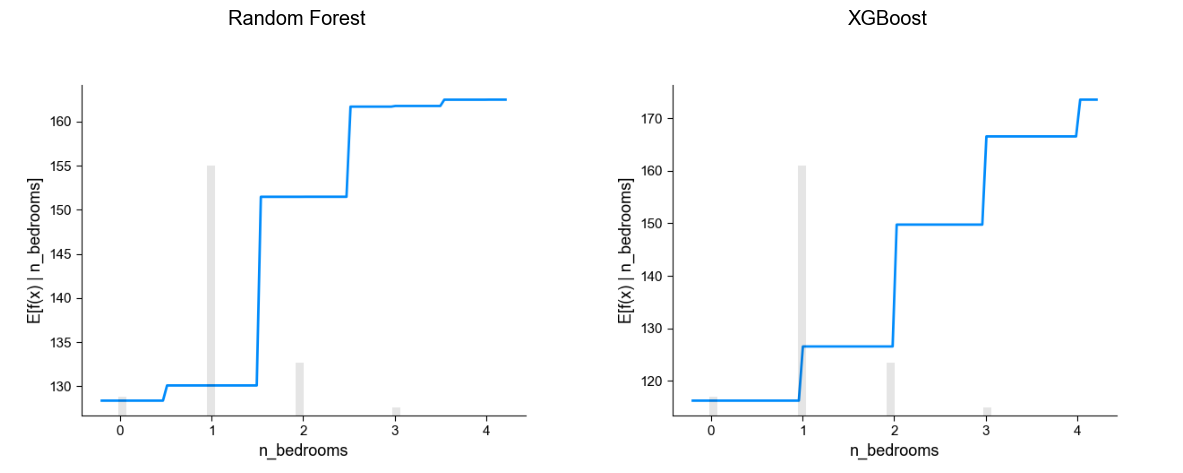

In [146]:
plot_partial_dependence_comparison('n_bedrooms', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_host_since` - \#9 for RF, \#4 for XGBoost**

The more ridged prediction for XGBoost is even more apparent in the cose of the days since host variable. In this case, the Random Forest shows a rather simple U-shaped relationship. In contrast, the XGBoost shows a very ridged functional form, in which a U-shape is hardly identifiable.

The U-shape of the Random Forest suggests that price is expected to be lower for listings with longer since-host-time. However, this pattern reverses at around 10 years, after which AirBnBs having hosts being hosts longer are more and more expensive.

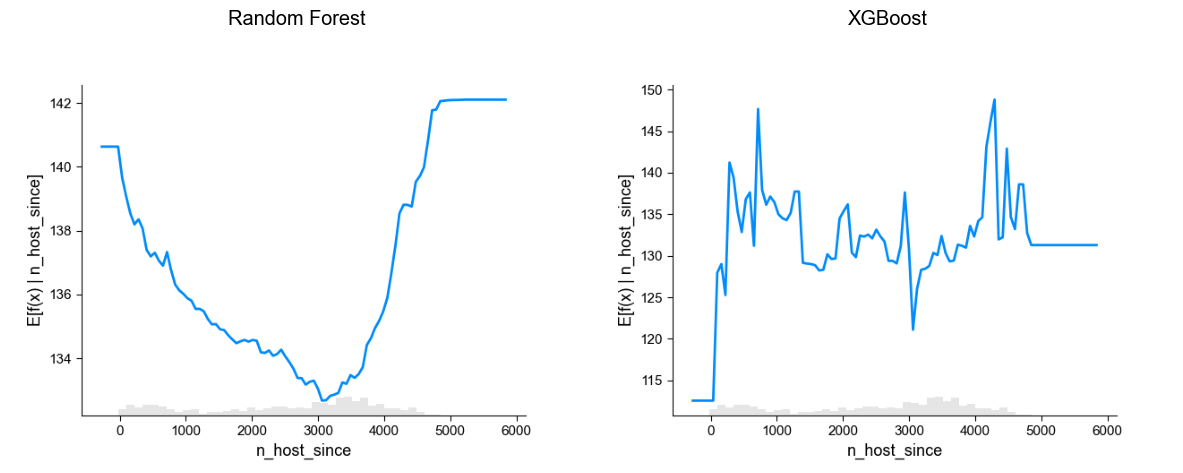

In [147]:
plot_partial_dependence_comparison('n_host_since', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_accomodates` - \#4 for RF, \#6 for XGBoost**

Similarly to what we have seen for the number of bedrooms, we can observe that both models suggest that the more people can be accomodated in an AirBnB, the higher the price is. Again, the price difference between each value is not uniform, and the two models suggest different price differences.

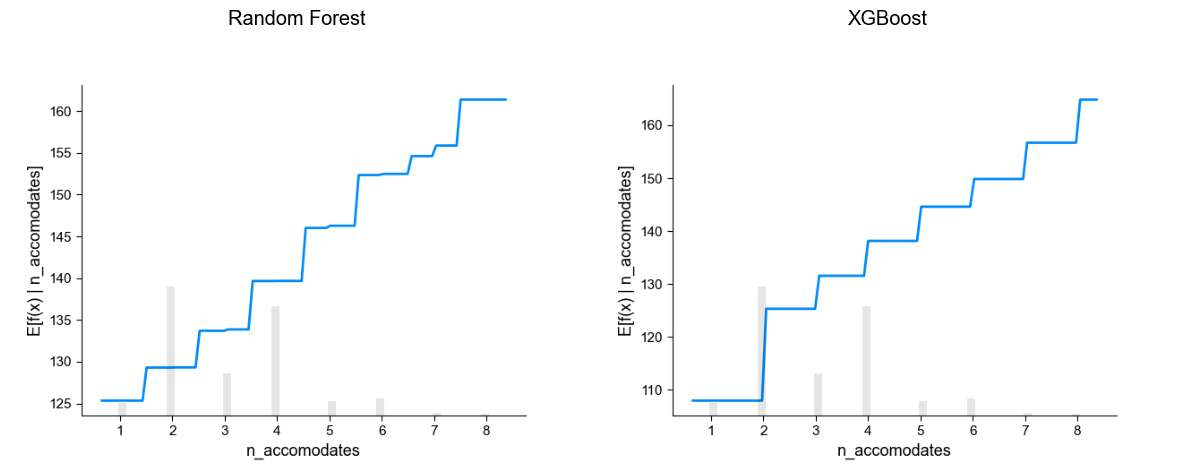

In [148]:
plot_partial_dependence_comparison('n_accomodates', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

Next, let's compare the two models according to SHAP values as well. Note that here, I did not display the plots next to each other as that way they would have been too cramped. Also, I only show the beeswarm plots, as I believe these are the most informative.

# Note: computing SHAP values may take a considerable amount of time, so you can also import the SHAP values from dill files later.

In [149]:
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

# without approximation, running this took many hours
rf_explainer = shap.TreeExplainer(rf_best_pipeline["regressor"], approximate = True)
rf_shap_values = rf_explainer(X_holdout)

In [150]:
with open(Path("rf_shap_values.dill"), "wb") as f:
    dill.dump(rf_shap_values, f)

In [151]:
X_encoded = xgb_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in xgb_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

xgb_explainer = shap.TreeExplainer(xgb_best_pipeline["regressor"])
xgb_shap_values = xgb_explainer(X_holdout)

In [153]:
with open(Path("xgb_shap_values.dill"), "wb") as f:
    dill.dump(xgb_shap_values, f)

# NOTE: Run from here again, to import the pre-calculated SHAP-values from dills.

In [154]:
with open(Path("rf_shap_values.dill"), "rb") as f:
    rf_shap_values = dill.load(f)
with open(Path("xgb_shap_values.dill"), "rb") as f:
    xgb_shap_values = dill.load(f)

For both models, the features deemed the most important by the SHAP values are more or less the same as we have seen on the variable importance plots. The most important feature is the distance to the center with a pretty large spread in SHAP values. The coloring suggests that lower distance is associated with a higher price.

The second most important feature is the number of bedrooms, with higher numbers being associated with higher prices in both models. The number of people accomodated is also an important feature, with naturally, higher values being associated with higher predictions.

The number of reviews per month is another important feature in both models, for which lower values are associated with higher prices.

Note that on the below plot, the number of bathrooms categorical variable is shown separetly for each value, so we cannot really make meaningful claims about it.

For the XGBoost model, the `n_host_since` variable is also quite important. However, it is rather mixed whether higher values contribute to lower or higher predictions, indicating the possibility of an interaction with another variable.

RANDOM FOREST


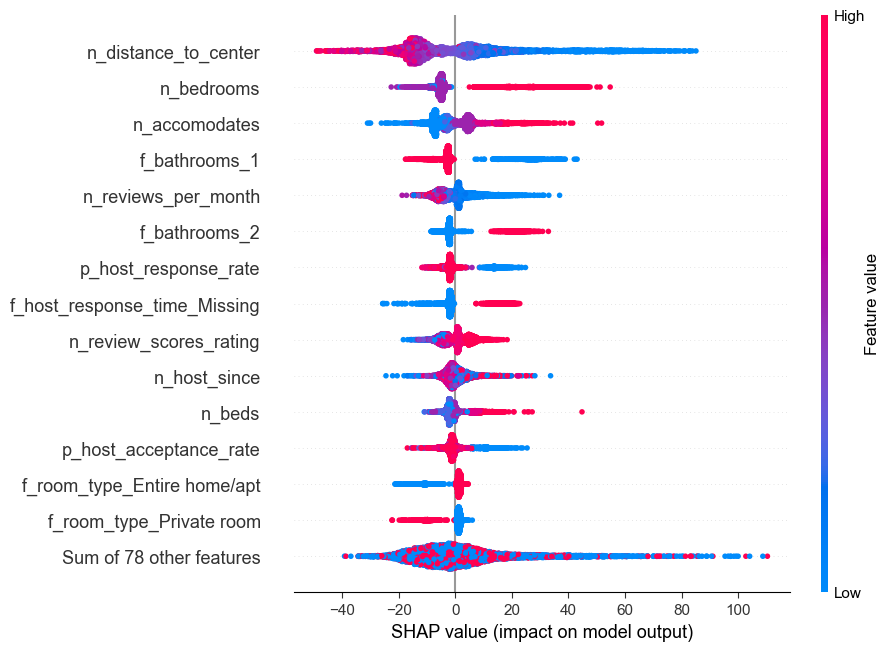

In [155]:
print('RANDOM FOREST')
shap.plots.beeswarm(rf_shap_values, max_display = 15, show = True)

XGBOOST


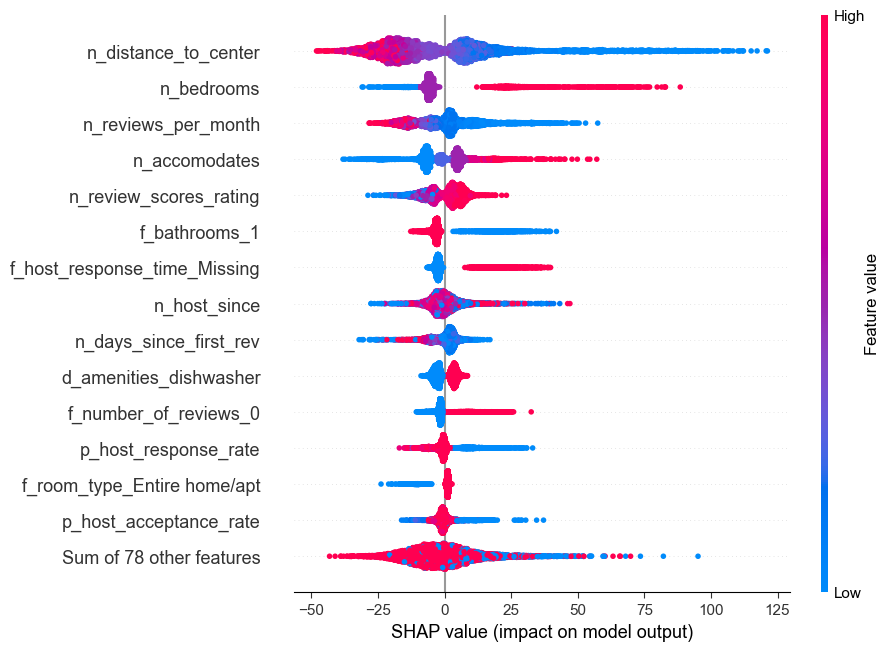

In [156]:
print('XGBOOST')
shap.plots.beeswarm(xgb_shap_values, max_display = 15, show = True)

Out of pure curiosity, we can check with SHAP what might be the most suitable interaction variable for `n_host_since`. For the Random Forest model, the package suggest the host response rate, while for the XGBoost model, the host acceptance rate. This might explain what we have seen and noted on the beeswarm plots.

RANDOM FOREST


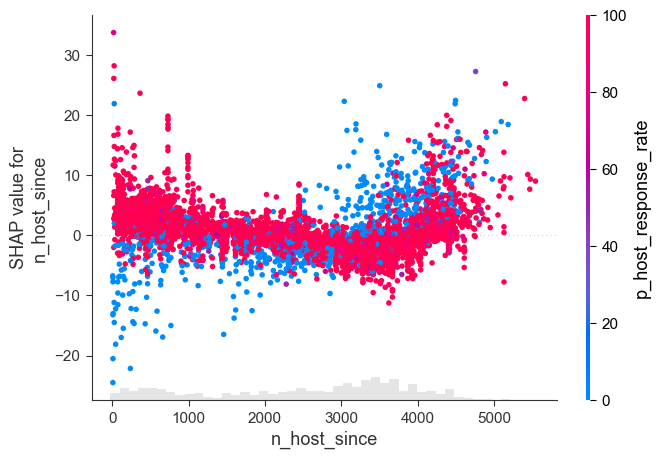

In [157]:
print('RANDOM FOREST')
shap.plots.scatter(rf_shap_values[:, "n_host_since"], color=rf_shap_values)

XGBOOST


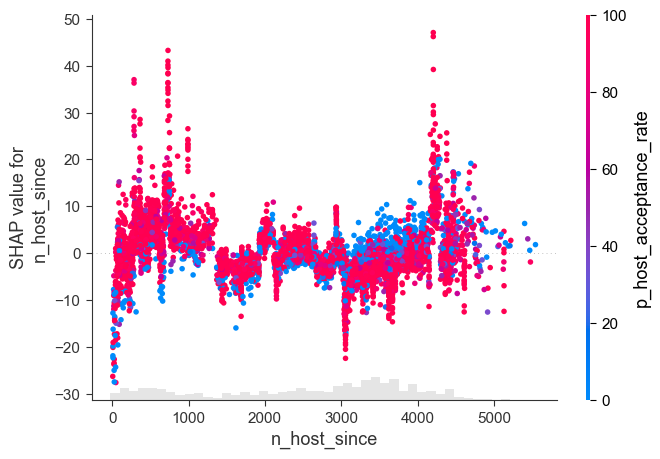

In [158]:
print('XGBOOST')
shap.plots.scatter(xgb_shap_values[:, "n_host_since"], color=xgb_shap_values)

The next thing to do is to check the performance of our models on certain subsamples. This might help us understand the constraints of our models and assess under which circumstances we can expect good predictive performance.

In [159]:
data_holdout_pred = data_holdout.assign(
    rf_pred = rf_best_pipeline.predict(data_holdout[list(predictors_ml)]),
    xgb_pred = xgb_best_pipeline.predict(data_holdout[list(predictors_ml)])
)

In [175]:
def calculate_rmse(groupby_obj, model):
    if model == 'rf':
        return (
            groupby_obj.apply(
                lambda x: mean_squared_error(x.rf_pred, x.eur_price, squared=False),
            )
            .to_frame(name="RF_rmse")
            .assign(RF_mean_price=groupby_obj.apply(lambda x: np.mean(x.eur_price)).values)
            .assign(RF_rmse_norm=lambda x: x.RF_rmse / x.RF_mean_price)
            .round(2)
        )
    else:
        return (
            groupby_obj.apply(
                lambda x: mean_squared_error(x.xgb_pred, x.eur_price, squared=False),
            )
            .to_frame(name="XGB_rmse")
            .assign(XGB_mean_price=groupby_obj.apply(lambda x: np.mean(x.eur_price)).values)
            .assign(XGB_rmse_norm=lambda x: x.XGB_rmse / x.XGB_mean_price)
            .round(2)
        )

In [170]:
data_holdout_pred = data_holdout_pred.assign(
    distance_cat = pd.cut(data_holdout_pred.n_distance_to_center,
                          bins = pd.IntervalIndex.from_tuples(
                              [(0, 2), (2, 4), (4, 6), (6, max(data_holdout_pred.n_distance_to_center)+1)], closed="left"
                              ), labels = ['0-2', '2-4', '4-6', '6+']),
    size_cat = pd.cut(data_holdout_pred.n_accomodates,
                          bins = pd.IntervalIndex.from_tuples(
                              [(1, 2), (2, 5), (5, max(data_holdout_pred.n_accomodates)+1)], closed="left"
                              ), labels = ['1', '2-4', '4+'])                    
)

In [190]:
rf_distance_rmse = calculate_rmse(data_holdout_pred.groupby('distance_cat'), 'rf')
xgb_distance_rmse = calculate_rmse(data_holdout_pred.groupby('distance_cat'), 'xgb')

rf_size_rmse = calculate_rmse(data_holdout_pred.groupby('size_cat'), 'rf')
xgb_size_rmse = calculate_rmse(data_holdout_pred.groupby('size_cat'), 'xgb')

rf_room_type_rmse = calculate_rmse(data_holdout_pred.groupby('f_room_type'), 'rf')
xgb_room_type_rmse = calculate_rmse(data_holdout_pred.groupby('f_room_type'), 'xgb')

In [191]:
rf_distance_rmse.index = ['0-2 km', '2-4 km', '4-6 km', '6+ km']
xgb_distance_rmse.index = ['0-2 km', '2-4 km', '4-6 km', '6+ km']

rf_size_rmse.index = ['1 ppl', '2-4 ppl', '4+ ppl']
xgb_size_rmse.index = ['1 ppl', '2-4 ppl', '4+ ppl']

In [192]:
distance_rmse = pd.concat([rf_distance_rmse, xgb_distance_rmse], axis = 1)
size_rmse = pd.concat([rf_size_rmse, xgb_size_rmse], axis = 1)
room_type_rmse = pd.concat([rf_room_type_rmse, xgb_room_type_rmse], axis = 1)

In [193]:
all_holdout_rf = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_pred.eur_price,
                data_holdout_pred.rf_pred,
                squared=False,
            ),
            data_holdout_pred.eur_price.mean(),
        ],
        index=["RF_rmse", "RF_mean_price"],
    )
    .T.assign(RF_rmse_norm=lambda x: x.RF_rmse / x.RF_mean_price)
    .round(2)
)
all_holdout_rf.index = ["All"]

all_holdout_xgb = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_pred.eur_price,
                data_holdout_pred.xgb_pred,
                squared=False,
            ),
            data_holdout_pred.eur_price.mean(),
        ],
        index=["XGB_rmse", "XGB_mean_price"],
    )
    .T.assign(XGB_rmse_norm=lambda x: x.XGB_rmse / x.XGB_mean_price)
    .round(2)
)
all_holdout_xgb.index = ["All"]

all_holdout = pd.concat([all_holdout_rf, all_holdout_xgb], axis=1)


In [204]:
type_rows = pd.DataFrame(
    None,
    index=["Distance (km)", "Size (ppl)", "Type", "---"],
    columns=["RF_rmse", "RF_mean_price", "RF_rmse_norm", "XGB_rmse", "XGB_mean_price", "XGB_rmse_norm"],
).fillna("")

In [206]:
subsample_perf = pd.concat(
    [
        type_rows.iloc[[0]],
        distance_rmse,
        type_rows.iloc[[1]],
        size_rmse,
        type_rows.iloc[[2]],
        room_type_rmse,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

subsample_perf.drop(columns = ['RF_mean_price'], inplace = True)
subsample_perf.columns = ['RF RMSE', 'RF RMSE (normalized)', 'XGB RMSE', 'Mean price', 'XGB RMSE (normalized)']
subsample_perf = subsample_perf.filter(['Mean price', 'RF RMSE', 'XGB RMSE', 'RF RMSE (normalized)', 'XGB RMSE (normalized)'])
subsample_perf

Mean price RF RMSE XGB RMSE RF RMSE (normalized)  \
Distance (km)                                                      
0-2 km              165.46   64.91    61.25                 0.39   
2-4 km              124.92   58.03    57.68                 0.46   
4-6 km               109.5   56.13    54.43                 0.51   
6+ km                102.1   56.81    57.49                 0.56   
Size (ppl)                                                         
1 ppl                85.69   52.81    52.57                 0.62   
2-4 ppl              127.5   57.03     56.0                 0.45   
4+ ppl              189.05   78.98    74.18                 0.42   
Type                                                               
Entire home/apt     137.56   60.71    58.86                 0.44   
Private room         95.53   51.46    52.65                 0.54   
---                                                                
All                 132.65    59.7    58.17                 0.45   

                XGB RMSE (normalized)  
Distance (km)                          
0-2 km                           0.37  
2-4 km                           0.46  
4-6 km                            0.5  
6+ km                            0.56  
Size (ppl)                             
1 ppl                            0.61  
2-4 ppl                          0.44  
4+ ppl                           0.39  
Type                                   
Entire home/apt                  0.43  
Private room                     0.55  
---                                    
All                              0.44

Looking at the normalized RMSE values, we can conclude that the two models are very much comparable in their subsample performances, with XGBoost having a very slight advantage. This advantage is more apparent in two cases: for listings very close to the city center (below 2 kilometers), and for listings that can accomodate more than 4 people - however, the advantage is not substantial even in these cases.

Generally, model performance decreases, the further away a listing is from the center and the less people it can accomodate. In addition, model performance is worse for private rooms than for entire homes or apartments.

Thus, we can expect that on live data that would have

- more spread out listings regarding distance to the center;
- more listings with a lower number of people that can be accomodated;
- or more entire homes and apartments

the models would perform worse than on the Milan Q2 set.

Finally, we can also look at a simple y_hat - y plot for the models to identify in which price ranges they perform well or badly.

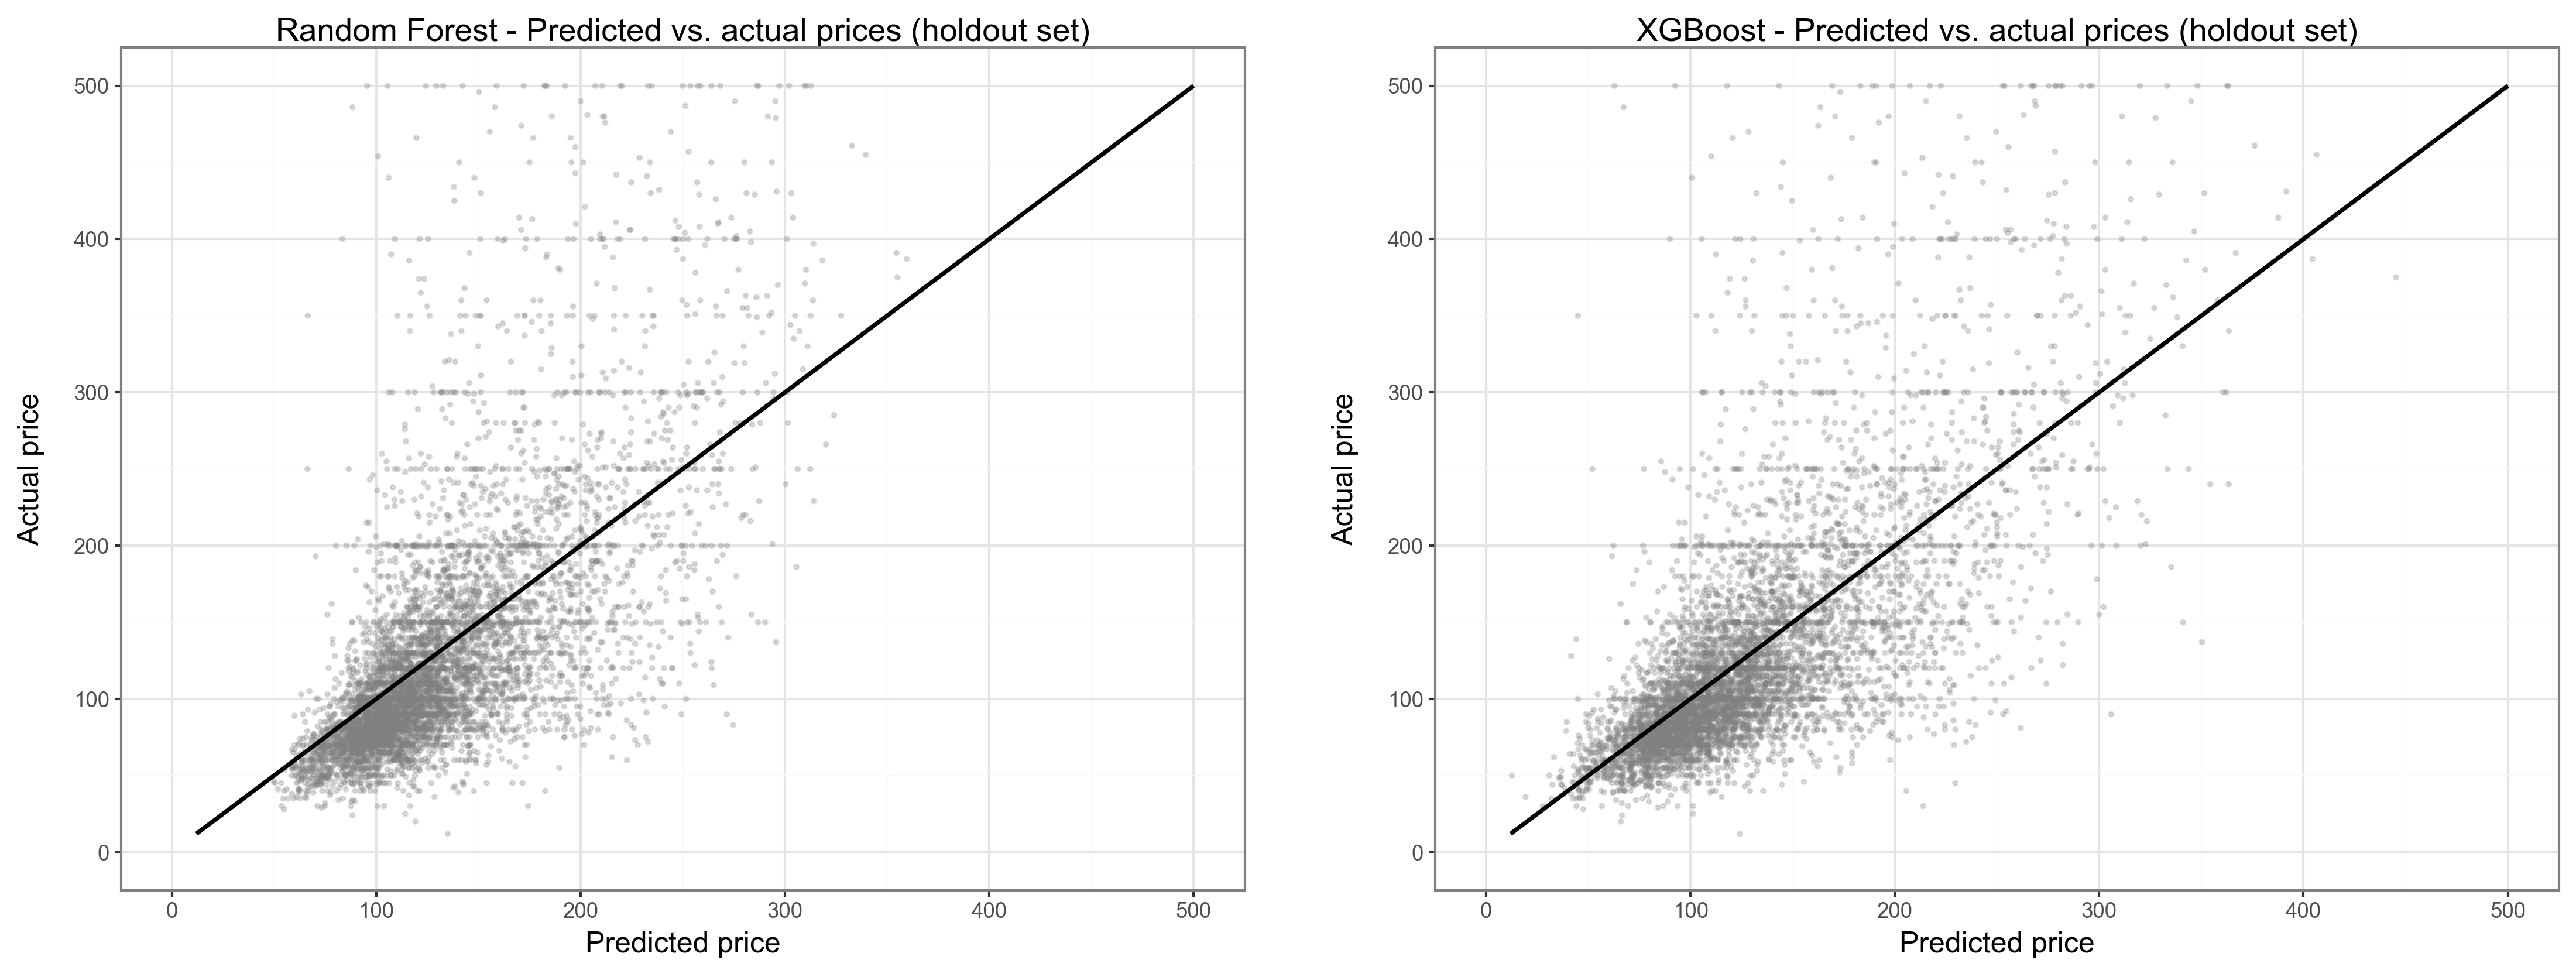

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [230]:
p1 = (
    ggplot(data_holdout_pred, aes(x="rf_pred", y="eur_price"))
    + geom_point(color='grey', size=0.5, alpha=0.25)
    + geom_line(aes(x="eur_price", y="eur_price"), color='black', size=1)
    + theme_bw()
    + labs(title='Random Forest - Predicted vs. actual prices (holdout set)',
           x='Predicted price', y='Actual price')
    + scale_x_continuous(limits=(0, 500), breaks=range(0, 501, 100))
    + scale_y_continuous(limits=(0, 500), breaks=range(0, 501, 100))
)

p2 = (
    ggplot(data_holdout_pred, aes(x="xgb_pred", y="eur_price"))
    + geom_point(color='grey', size=0.5, alpha=0.25)
    + geom_line(aes(x="eur_price", y="eur_price"), color='black', size=1)
    + theme_bw()
    + labs(title='XGBoost - Predicted vs. actual prices (holdout set)',
           x='Predicted price', y='Actual price')
    + scale_x_continuous(limits=(0, 500), breaks=range(0, 501, 100))
    + scale_y_continuous(limits=(0, 500), breaks=range(0, 501, 100))
)

pw.basefigure.clear()
display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

Generally speaking, the above plots tell us that the patterns identified by either of the models hold well for the below 150 EUR range. But after that point, both models lose accuracy, shown by an increasing spread around the 45-degree line. Also, the XGBoost model seems to be slightly more precise for higher price values - but this comes with the cost that it seems less accurate for lower price values.

We can also note that for the XGBoost model, the predicted prices are spread out relatively evenly around the 45-degree line. On the contrary, for the Random Forest, we can see that the model more often overpredicts the actual price (dots below the 45-degree line). This might mean that the Random Forest model is more biased (I will test this next.).

In [234]:
print(f'RF mean prediction error (bias): {round(np.mean(data_holdout_pred.rf_pred - data_holdout_pred.eur_price),2)}')
print(f'XGB mean prediction error (bias): {round(np.mean(data_holdout_pred.xgb_pred - data_holdout_pred.eur_price),2)}')

RF mean prediction error (bias): 2.38
XGB mean prediction error (bias): -0.05


The above calculation confirms the visual observation that the Random Forest prediction is indeed more biased in the direction of overprediction.

## Part 2: Validity
### 2.5. 'Live' dataset import and cleaning

This has already been done (see section 1.1).

### 2.6. Evaluating model performance on 'live' data

First, to utilize all available training data, I will re-estimate all models using the complete MilanQ2 dataset (that is, both the training and the hold-out set).

In [207]:
y, X = dmatrices("eur_price" + ols_equations[3], milanQ2)
ols_complete = LinearRegression().fit(X, y)

In [208]:
y, X = dmatrices("eur_price" + ols_equations[5], milanQ2)
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1, random_state=9876))])

In [209]:
rf_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [210]:
gbm_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=200,
                                           random_state=31))])

In [211]:
xgb_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

Now we can make some predictions on the live datasets. Importantly, in a real use case, we would have no way to calculate RMSE values for the live data (as it would be live, without price values available). However, we now have price inside our live sets as well, so we can calculate the models' RMSE values there as well.

An important caveat, however, is that before, I intentionally did not filter out observations with possible errors or extreme values in the price variable (as in real live data, we could not do that). However, when calculating the RMSE values, these errors very much inflate the results. So, I below present two RMSE values for both datasets: one without filtering out erronous prices, and one with filtering these out. I believe this second measure captures much better how well my models generalize to other time periods or other areas.

In [212]:
milanQ3_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3)
milanQ3_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3)
milanQ3_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_rmse['rf'] = mean_squared_error(milanQ3['eur_price'], rf_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['gbm'] = mean_squared_error(milanQ3['eur_price'], gbm_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['xgb'] = mean_squared_error(milanQ3['eur_price'], xgb_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)

In [213]:
milanQ3_clean = milanQ3[milanQ3['eur_price'] <= 500]

In [214]:
milanQ3_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3_clean)
milanQ3_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3_clean)
milanQ3_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_clean_rmse['rf'] = mean_squared_error(milanQ3_clean['eur_price'], rf_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['gbm'] = mean_squared_error(milanQ3_clean['eur_price'], gbm_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['xgb'] = mean_squared_error(milanQ3_clean['eur_price'], xgb_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)

In [215]:
florenceQ2_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2)
florenceQ2_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2)
florenceQ2_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_rmse['rf'] = mean_squared_error(florenceQ2['eur_price'], rf_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['gbm'] = mean_squared_error(florenceQ2['eur_price'], gbm_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['xgb'] = mean_squared_error(florenceQ2['eur_price'], xgb_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)

In [216]:
florenceQ2_clean = florenceQ2[florenceQ2['eur_price'] <= 500]

In [217]:
florenceQ2_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2_clean)
florenceQ2_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2_clean)
florenceQ2_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_clean_rmse['rf'] = mean_squared_error(florenceQ2_clean['eur_price'], rf_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['gbm'] = mean_squared_error(florenceQ2_clean['eur_price'], gbm_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['xgb'] = mean_squared_error(florenceQ2_clean['eur_price'], xgb_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)

Let's first discuss validity on the Milan Q3 dataset! As mentioned before, I will concentrate on the RMSE values when the price errors have been removed.

First note that the Milan Q3 RMSE values are higher for all of the models then they were on the hold-out sample. This is especially true in the case of the OLS, LASSO and GBM models, meaning that they fail to generalize to a new time period. From the Random Forest and XGBoost models, Random Forest generalizes substantially better to this 'live' dataset.

As for the Florence Q2 set, the RMSE values are even higher than for Milan Q3. This indicates that the models generalize worse to another city than to another time period. The best model again is the Random Forest - but interestingly, the LASSO set-up now ranks higher than XGBoost.

All in all, we can conclude that:

- generalization to a new city is harder for the models than to a new time period in the same city;
- overall, the Random Forest model generalizes the best for both types of live data.

Thus, if we were to employ any of these models in real life, I would recommend using the Random Forest. This would be a good choice both in terms of training time and performance.

In [218]:
live_rmse = pd.DataFrame({
    'Milan Q3 RMSE' : milanQ3_rmse,
    'Milan Q3 RMSE (price errors removed)' : milanQ3_clean_rmse,
    'Florence Q2 RMSE' : florenceQ2_rmse,
    'Florence Q2 RMSE (price errors removed)' : florenceQ2_clean_rmse
}).round(2)

live_rmse.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

live_rmse['CV test RMSE'] = horserace['CV test RMSE']
live_rmse['Hold-out set RMSE'] = horserace['Hold-out set RMSE']

live_rmse = live_rmse[['CV test RMSE', 'Hold-out set RMSE', 
                       'Milan Q3 RMSE', 'Milan Q3 RMSE (price errors removed)', 
                       'Florence Q2 RMSE', 'Florence Q2 RMSE (price errors removed)']]

live_rmse

CV test RMSE  Hold-out set RMSE  Milan Q3 RMSE  \
OLS                   61.77              62.67        1132.74   
LASSO                 61.72              62.22        1132.73   
Random Forest         60.00              59.70        1132.02   
GBM                   59.09              58.98        1132.17   
XGBoost               58.57              58.17        1132.20   

               Milan Q3 RMSE (price errors removed)  Florence Q2 RMSE  \
OLS                                           71.83            266.97   
LASSO                                         71.33            267.55   
Random Forest                                 61.54            269.45   
GBM                                           67.84            266.10   
XGBoost                                       66.31            265.66   

               Florence Q2 RMSE (price errors removed)  
OLS                                              69.09  
LASSO                                            68.01  
Random Forest                                    67.26  
GBM                                              69.38  
XGBoost                                          68.31